In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set working directory to '/n/groups/patel/shakson/aiready/'
import os
os.chdir("/home/shaksonisaac/CGM/mambatf/")

#LOAD Datasets
import pandas as pd
import io
from google.cloud import storage

_BUCKET_NAME = "cgmproject2025"

# Download dataset from GCS
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/train_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
train = pd.read_feather(io.BytesIO(data_bytes))


# Download test set:
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/test_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
test = pd.read_feather(io.BytesIO(data_bytes))

# Download measurement data:
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/clinical/measurement.csv')
data_bytes = blob.download_as_bytes()
measurement = pd.read_csv(io.BytesIO(data_bytes))

# Convert measurement from long to wide format: person_id as index, measurement_source_value as columns, and value_source_value as values
measurement_wide = measurement.pivot_table(index='person_id',
                                           columns='measurement_source_value',
                                           values='value_as_number',
                                           aggfunc='first').reset_index()
measurement_wide.columns.name = None  # Remove the name of the columns index
measurement_wide = measurement_wide.rename(columns={'person_id': 'participant_id'})

# Load Results HR and RR 2std increase csv
import pandas as pd
HR = pd.read_csv('./counterfactual/Results/HR_2std_minvalues.csv')
RR = pd.read_csv('./counterfactual/Results/RR_2std_minvalues.csv')

In [3]:
# Combine HR and RR dataframes on 'participant_id' and 'min_value' columns
CFvoi = pd.merge(HR, RR, on=['participant_id', 'study_group'],   suffixes=('_HR', '_RR'))
CFvoi   

,participant_id,min_value_HR,study_group,min_value_RR
0,1023,-0.366218,insulin_dependent,-0.843351
1,1024,-2.669307,pre_diabetes_lifestyle_controlled,1.016263
2,1026,-7.312077,pre_diabetes_lifestyle_controlled,1.560739
3,1027,-9.020710,oral_medication_and_or_non_insulin_injectable_...,-6.858631
4,1028,-9.470850,oral_medication_and_or_non_insulin_injectable_...,1.627976
...,...,...,...,...
736,7405,-0.850099,oral_medication_and_or_non_insulin_injectable_...,2.799107
737,7406,-3.782544,oral_medication_and_or_non_insulin_injectable_...,1.506696
738,7407,-7.050296,oral_medication_and_or_non_insulin_injectable_...,1.221859
739,7409,-2.165680,insulin_dependent,1.006962


In [4]:
CFvoi['study_group'] = CFvoi['study_group'].replace({
    'healthy': 'Healthy',
    'pre_diabetes_lifestyle_controlled': 'Pre-diabetes',
    'oral_medication_and_or_non_insulin_injectable_medication_controlled': 'Diabetes - Oral',
    'insulin_dependent': 'Diabetes - Insulin'
})
print(CFvoi)

     participant_id  min_value_HR         study_group  min_value_RR
0              1023     -0.366218  Diabetes - Insulin     -0.843351
1              1024     -2.669307        Pre-diabetes      1.016263
2              1026     -7.312077        Pre-diabetes      1.560739
3              1027     -9.020710     Diabetes - Oral     -6.858631
4              1028     -9.470850     Diabetes - Oral      1.627976
..              ...           ...                 ...           ...
736            7405     -0.850099     Diabetes - Oral      2.799107
737            7406     -3.782544     Diabetes - Oral      1.506696
738            7407     -7.050296     Diabetes - Oral      1.221859
739            7409     -2.165680  Diabetes - Insulin      1.006962
740            7411     -0.119403     Diabetes - Oral     -1.113217

[741 rows x 4 columns]


In [5]:
# Get average min_value_HR and RR across the population:
avg_min_value_HR = CFvoi['min_value_HR'].mean()
avg_min_value_RR = CFvoi['min_value_RR'].mean()
print(f"Average min_value_HR: {avg_min_value_HR}")
print(f"Average min_value_RR: {avg_min_value_RR}")

Average min_value_HR: -5.01198381265857
Average min_value_RR: 1.240617340895641


## Figure showing average counterfactual effect of heart rate and respiration rate

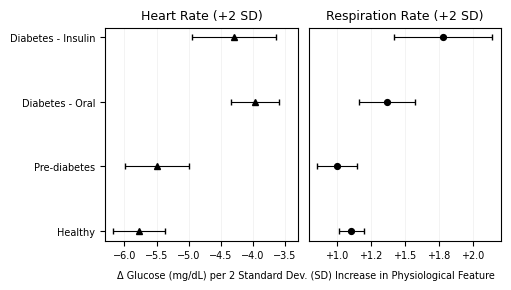

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats

df = CFvoi.copy()

# df must have: participant_id, min_value_HR, min_value_RR, study_group
# Example order (edit if yours differs)
ORDER = ["Healthy", "Pre-diabetes", "Diabetes - Oral", "Diabetes - Insulin"]

def summarize_per_group(df, col, order=ORDER):
    g = df.groupby("study_group")[col]
    n = g.size()
    m = g.mean()
    se = g.sem()
    tcrit = stats.t.ppf(0.975, n-1)        # 95% CI
    lo = m - tcrit * se
    hi = m + tcrit * se
    out = pd.DataFrame({"study_group": m.index, "mean": m.values,
                        "lo": lo.values, "hi": hi.values})
    out = out.set_index("study_group").loc[order].reset_index()
    return out

hr = summarize_per_group(df, "min_value_HR")
rr = summarize_per_group(df, "min_value_RR")

# ---------- figure style tuned for a small NeurIPS sub-panel ----------
plt.rcParams.update({
    "font.size": 8,           # base font
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "lines.markersize": 4.5,
    "lines.linewidth": 1.0,
})

# Total size ~4.8 in wide x 2.6 in tall; adjust if you need even smaller
fig, axes = plt.subplots(1, 2, figsize=(5, 2.6), sharey=True)

y = np.arange(len(ORDER))

# ---- Left: Heart Rate (triangles) ----
ax = axes[0]
ax.errorbar(
    hr["mean"], y,
    xerr=[hr["mean"]-hr["lo"], hr["hi"]-hr["mean"]],
    fmt="^", capsize=2, elinewidth=0.8, markersize=4.2, color="black"
)
ax.set_title("Heart Rate (+2 SD)")
ax.set_yticks(y); ax.set_yticklabels(ORDER)

ax.grid(axis="x", alpha=0.2, lw=0.5)
ax.set_xlim(-6.3, -3.3)
ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"{x:+.1f}".replace("-", "−"))
)
#ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:+.1f}"))
# The + in f-string ensures positive numbers show +, e.g. +1.0


# ---- Right: Respiration Rate (circles) ----
ax = axes[1]
ax.errorbar(
    rr["mean"], y,
    xerr=[rr["mean"]-rr["lo"], rr["hi"]-rr["mean"]],
    fmt="o", capsize=2, elinewidth=0.8, markersize=4.2, color="black"
)
ax.set_title("Respiration Rate (+2 SD)")

ax.grid(axis="x", alpha=0.2, lw=0.5)
ax.tick_params(axis="y", length=0)  # suppress repeat y ticks
#ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:+.1f}"))
# The + in f-string ensures positive numbers show +, e.g. +1.0
ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"{x:+.1f}".replace("-", "−"))
)

# Adjust spacing between subplots
#fig.subplots_adjust(wspace=1)  # increase from default (~0.2). Try 0.35–0.5 for clarity.

# Tight layout with small top margin for a panel letter if needed
fig.text(0.6, -0.02, r'Δ Glucose (mg/dL) per 2 Standard Dev. (SD) Increase in Physiological Feature', ha='center', va='top', fontsize=7)
fig.tight_layout(pad=0.4, w_pad=1.0)


# High-DPI export (PNG and PDF)
plt.savefig("./figures/HR_RR_counterfactuals.png", dpi=1000, bbox_inches="tight")
plt.savefig("./figures/HR_RR__counterfactuals.pdf", bbox_inches="tight")
plt.savefig("./figures/HR_RR__counterfactuals.svg", bbox_inches="tight")
# Shared label (short, counterfactual explicit)
plt.show()

## Figure showing correlations between counterfactuals with other clinical measures (lab values)

In [18]:
# what is correlation between counterfactuals and other clinical measures (lab values)
# Load the measurement data
measurement = measurement_wide.copy()
# Convert participant_id to string for consistency
#measurement['participant_id'] = measurement['participant_id'].astype(str)
# Merge the counterfactual data with the measurement data
merged_data = pd.merge(CFvoi, measurement, on='participant_id', how='left')
print(merged_data)

     participant_id  min_value_HR         study_group  min_value_RR  \
0              1023     -0.366218  Diabetes - Insulin     -0.843351   
1              1024     -2.669307        Pre-diabetes      1.016263   
2              1026     -7.312077        Pre-diabetes      1.560739   
3              1027     -9.020710     Diabetes - Oral     -6.858631   
4              1028     -9.470850     Diabetes - Oral      1.627976   
..              ...           ...                 ...           ...   
736            7405     -0.850099     Diabetes - Oral      2.799107   
737            7406     -3.782544     Diabetes - Oral      1.506696   
738            7407     -7.050296     Diabetes - Oral      1.221859   
739            7409     -2.165680  Diabetes - Insulin      1.006962   
740            7411     -0.119403     Diabetes - Oral     -1.113217   

     A/G Ratio  ALT (IU/L)  AST (IU/L)  Albumin (g/dL)  \
0     2.333333        37.0        23.0             4.2   
1     1.769231         9.0     

In [19]:
merged_data.columns[0:50]

Index(['participant_id', 'min_value_HR', 'study_group', 'min_value_RR',
       'A/G Ratio', 'ALT (IU/L)', 'AST (IU/L)', 'Albumin (g/dL)',
       'Alkaline Phosphatase (IU/L)', 'BUN (mg/dL)', 'BUN/Creatinine ratio',
       'Bilirubin, Total (mg/dL)', 'C-Peptide (ng/mL)', 'CRP - HS (mg/L)',
       'Calcium (mg/dL)', 'Carbon Dioxide, Total (mEq/L)', 'Chloride (mEq/L)',
       'Creatinine (mg/dL)', 'Globulin, Total (g/dL)', 'Glucose (mg/dL)',
       'HDL Cholesterol (mg/dL)', 'HbA1c (%)', 'INSULIN (ng/mL)',
       'LDL Cholesterol Calculation (mg/dL)', 'NT-proBNP (pg/mL)',
       'Potassium (mEq/L)', 'Protein, Total (g/dL)', 'Sodium (mEq/L)',
       'Total Cholesterol (mg/dL)', 'Triglycerides (mg/dL)',
       'Troponin-T (ng/L)', 'Urine Albumin (mg/dL)',
       'Urine Creatinine (mg/dL)', 'bmi_vsorres, BMI',
       'bp1_diabp_vsorres, Diastolic (mmHg)',
       'bp1_sysbp_vsorres, Systolic (mmHg)',
       'bp2_diabp_vsorres, Diastolic (mmHg)',
       'bp2_sysbp_vsorres, Systolic (mmHg)',
  

In [20]:
merged_data.columns[51:90]

Index(['lbscat_mchc, MCHC - g/dL', 'lbscat_mcv, MCV - fL',
       'lbscat_plt, Platelets - x10E3/µL',
       'lbscat_rbc, Red Blood Cells (RBC) - x10E6/µL', 'lbscat_rdw, RDW - %',
       'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL', 'lettera',
       'lettera_time', 'memory_trial1', 'memory_trial1_time', 'memory_trial2',
       'memory_trial2_time', 'mlcsodfcl, OD: Value of final correct letter',
       'mlcsodlog, OD: Log Contrast Sensitivity',
       'mlcsodmiss, OD: Number of misses prior to stoppin',
       'mlcsosfcl, OS: Value of final correct letter',
       'mlcsoslog, OS: Log Contrast Sensitivity',
       'mlcsosmiss, OS: Number of misses prior to stoppin', 'moca_abstraction',
       'moca_abstraction_time', 'moca_combined_mis_score', 'moca_orientation',
       'moca_orientation_time', 'moca_total_score',
       'msslffl, Left Foot - Felt:', 'mssrffl, Right Foot - Felt:', 'naming',
       'naming_time', 'plcsodfcl, OD: Value of final correct letter',
       'plcsodlog, OD:

In [21]:
merged_data.columns[91:120]

Index(['trails_visuospatial_executive', 'trails_visuospatial_executive_time',
       'viaodaxi, OD - Autorefractor - Axis',
       'viaodcyl, OD - Autorefractor - Cylinder',
       'viaodmlog, LLVA Letter Score - Mesopic VA - OD',
       'viaodmscore, Mesopic LogMAR OD Score',
       'viaodmsf, Snellen fraction - Mesopic VA - OD',
       'viaodplog, VA Letter Score - Photopic VA - OD',
       'viaodpscore, Photopic LogMAR OD Score',
       'viaodpsf, Snellen fraction - Photopic VA - OD',
       'viaodsph, OD - Autorefractor - Sphere',
       'viaosaxi, OS - Autorefractor - Axis',
       'viaoscyl, OS - Autorefractor - Cylinder',
       'viaosmlog, LLVA Letter Score - Mesopic VA - OS',
       'viaosmscore, Mesopic LogMAR OS Score',
       'viaosmsf, Snellen fraction - Mesopic VA - OS',
       'viaosplog, VA Letter Score - Photopic VA - OS',
       'viaospscore, Photopic LogMAR OS Score',
       'viaospsf, Snellen fraction - Photopic VA - OS',
       'viaossph, OS - Autorefractor - Spher

/tmp/ipykernel_12697/378046784.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_numbers = r_sub.applymap(fmt_signed)
/tmp/ipykernel_12697/378046784.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stars_grid = q_sub.applymap(star_str)


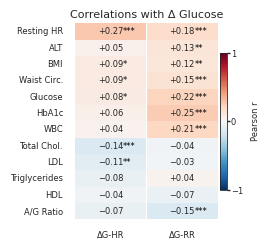

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import pdist

# --- rename the two CF columns for clarity in the inputs (if needed) ---
merged_data = merged_data.rename(columns={
    'min_value_HR': 'Δ Glucose via HR',
    'min_value_RR': 'Δ Glucose via RR'
})

correlation_columns = [
    'Δ Glucose via HR', 'Δ Glucose via RR',
    'HDL Cholesterol (mg/dL)', 'Triglycerides (mg/dL)',
    'HbA1c (%)', 'pulse_vsorres, Heart Rate (bpm)',
    'Glucose (mg/dL)', 'Total Cholesterol (mg/dL)',
    'bmi_vsorres, BMI', 'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL',
    'waist_vsorres, Waist Circumference (cm)',
    'A/G Ratio', 'ALT (IU/L)',
    'LDL Cholesterol Calculation (mg/dL)'
]

# ---------- compute pairwise r, p ----------
X = merged_data[correlation_columns].apply(pd.to_numeric, errors='coerce')

def pairwise_corr_p(df):
    cols = df.columns
    rmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    pmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    nmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    for i, ci in enumerate(cols):
        xi = df[ci]
        for j, cj in enumerate(cols):
            xj = df[cj]
            mask = xi.notna() & xj.notna()
            n = int(mask.sum())
            if n >= 3 and xi[mask].nunique() > 1 and xj[mask].nunique() > 1:
                r, p = pearsonr(xi[mask], xj[mask])
                rmat.iloc[i, j] = r
                pmat.iloc[i, j] = p
                nmat.iloc[i, j] = n
    return rmat, pmat, nmat

df_corr, df_pval, df_n = pairwise_corr_p(X)

# ---------- define focus ----------
focus = ['Δ Glucose via HR', 'Δ Glucose via RR']
phenos = [c for c in df_corr.columns if c not in focus]

# matrix for clustering (phenotypes × 2). z-score columns first; fillna only for ordering.
cluster_block = df_corr.loc[phenos, focus].astype(float)
Z = (cluster_block - cluster_block.mean()) / cluster_block.std(ddof=0)
Z = Z.fillna(0.0)

# hierarchical clustering with optimal leaf ordering
d = pdist(Z.values, metric='euclidean')
L = linkage(d, method='average')
L_opt = optimal_leaf_ordering(L, d)
row_order = cluster_block.index[leaves_list(L_opt)].tolist()

# ---------- ORIENT rows so the positive block sits on top ----------
# Compare the mean of the top vs bottom chunk; flip if needed.
k = max(1, int(np.ceil(0.35 * len(row_order))))  # use ~top/bottom 35% as a "block"
means = cluster_block.loc[row_order].mean(axis=1)
if means.iloc[:k].mean() < means.iloc[-k:].mean():
    row_order = row_order[::-1]

# (Optional STRICT variant: place all positive-mean rows above negative ones,
# preserving clustered order within each group.)
# pos = [r for r in row_order if means.loc[r] >= 0]
# neg = [r for r in row_order if means.loc[r] < 0]
# row_order = pos + neg

# ---------- MULTIPLE-TESTING CORRECTION BEFORE SUBSETTING ----------
FDR_METHOD = 'fdr_bh'
def fdr_over_phenotype_vs_focus(p_all, phenos, focus, method='fdr_bh'):
    block = p_all.loc[phenos, focus]
    flat = block.to_numpy().ravel()
    mask = ~np.isnan(flat)
    adj = np.full_like(flat, np.nan, dtype=float)
    if mask.any():
        adj[mask] = multipletests(flat[mask], method=method)[1]
    return pd.DataFrame(adj.reshape(block.shape), index=block.index, columns=block.columns)

q_all = fdr_over_phenotype_vs_focus(df_pval, phenos, focus, method=FDR_METHOD)

# ---------- subset AFTER adjustment ----------
r_sub = df_corr.loc[row_order, focus].copy()
q_sub = q_all.loc[row_order, focus].copy()

# ---------- labels ----------
rename = {
    'Δ Glucose via HR': 'ΔG-HR',
    'Δ Glucose via RR': 'ΔG-RR',
    'HDL Cholesterol (mg/dL)': 'HDL',
    'Triglycerides (mg/dL)': 'Triglycerides',
    'A/G Ratio': 'A/G Ratio',
    'ALT (IU/L)': 'ALT',
    'HbA1c (%)': 'HbA1c',
    'pulse_vsorres, Heart Rate (bpm)': 'Resting HR',
    'Glucose (mg/dL)': 'Glucose',
    'Total Cholesterol (mg/dL)': 'Total Chol.',
    "bmi_vsorres, BMI": "BMI",
    'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL': "WBC",
    'waist_vsorres, Waist Circumference (cm)': "Waist Circ.",
    'LDL Cholesterol Calculation (mg/dL)': 'LDL'
}
r_sub = r_sub.rename(index=rename, columns=rename)[['ΔG-HR', 'ΔG-RR']]
q_sub = q_sub.rename(index=rename, columns=rename)[['ΔG-HR', 'ΔG-RR']]

# ---------- formatting helpers ----------
MINUS = "\u2212"
def fmt_signed(x):
    if pd.isna(x): return ""
    return f"+{abs(x):.2f}" if x >= 0 else f"{MINUS}{abs(x):.2f}"

def star_str(q):
    if pd.isna(q): return ""
    return "***" if q < 1e-3 else ("**" if q < 1e-2 else ("*" if q < 5e-2 else ""))

annot_numbers = r_sub.applymap(fmt_signed)
stars_grid = q_sub.applymap(star_str)

# ---------- plot ----------
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":7, "axes.titlesize":8, "axes.labelsize":7,
                             "xtick.labelsize":6, "ytick.labelsize":6})

fig, ax = plt.subplots(figsize=(2.6, 2.4))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

hm = sns.heatmap(
    r_sub, annot=annot_numbers, fmt="",
    cmap="RdBu_r", norm=norm, linewidths=0,
    cbar=True, cbar_kws={"fraction":0.045, "pad":0.01},
    square=False, annot_kws={"ha":"center", "va":"center", "fontsize":6}
)

ax.set_xlabel(""); ax.set_ylabel("")
ax.set_title("Correlations with Δ Glucose", pad=4)
plt.xticks(rotation=0); plt.yticks(rotation=0)

# single column separator
ymin, ymax = ax.get_ylim()
ax.vlines(1, ymin, ymax, colors="white", linewidth=0.8)
for s in ax.spines.values(): s.set_visible(False)

cbar = hm.collections[0].colorbar
cbar.set_ticks([-1, 0, 1])
cbar.set_label("Pearson r", rotation=90, labelpad=6, fontsize=6)
cbar.ax.tick_params(labelsize=6, length=2, pad=1)
cbar.outline.set_linewidth(0.6)

# contrast tweak
threshold = 0.35
n_cols = r_sub.shape[1]
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        val = r_sub.loc[row, col]
        txt = hm.texts[y * n_cols + x]
        if abs(val) >= threshold:
            txt.set_color("white"); txt.set_fontweight("semibold")

# overlay stars to the right of numbers
x_dx = 0.17
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        s = stars_grid.loc[row, col]
        if s:
            star_color = "white" if abs(r_sub.loc[row, col]) >= threshold else "black"
            ax.text(x + 0.5 + x_dx, y + 0.5, s,
                    ha="left", va="center", fontsize=6, color=star_color, clip_on=False, zorder=5)

plt.tight_layout(pad=0.5)
plt.savefig("./figures/heatmap_delta_glucose_corr.png", dpi=600, bbox_inches="tight")
plt.savefig("./figures/heatmap_delta_glucose_corr.pdf", bbox_inches="tight")
plt.savefig("./figures/heatmap_delta_glucose_corr.svg", bbox_inches="tight")

plt.show()

# Prior Heatmap Versions Below

/tmp/ipykernel_14291/988954546.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_numbers = r_sub.applymap(fmt_signed)
/tmp/ipykernel_14291/988954546.py:128: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stars_grid = q_sub.applymap(star_str)


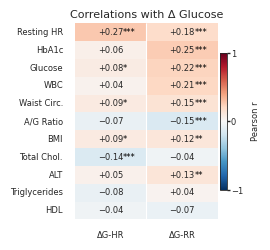

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# Rename min value columns for clarity
merged_data = merged_data.rename(columns={
    'min_value_HR': 'Δ Glucose via HR',
    'min_value_RR': 'Δ Glucose via RR'
})

# Calculate correlations between counterfactuals and other clinical measures
correlation_columns = ['Δ Glucose via HR', 'Δ Glucose via RR', 'HDL Cholesterol (mg/dL)', 'Triglycerides (mg/dL)', 
                       'HbA1c (%)', 'pulse_vsorres, Heart Rate (bpm)', 'Glucose (mg/dL)', 
                       'Total Cholesterol (mg/dL)', "bmi_vsorres, BMI",
                       'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL',
                       'waist_vsorres, Waist Circumference (cm)',
                       'A/G Ratio', 'ALT (IU/L)'
                       ]

# ---------- compute pairwise r, p ----------
X = merged_data[correlation_columns].apply(pd.to_numeric, errors='coerce')

def pairwise_corr_p(df):
    cols = df.columns
    rmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    pmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    nmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    for i, ci in enumerate(cols):
        xi = df[ci]
        for j, cj in enumerate(cols):
            xj = df[cj]
            mask = xi.notna() & xj.notna()
            n = int(mask.sum())
            if n >= 3 and xi[mask].nunique() > 1 and xj[mask].nunique() > 1:
                r, p = pearsonr(xi[mask], xj[mask])
                rmat.iloc[i, j] = r
                pmat.iloc[i, j] = p
                nmat.iloc[i, j] = n
    return rmat, pmat, nmat

df_corr, df_pval, df_n = pairwise_corr_p(X)

# ---------- define focus and row order ----------
focus = ['Δ Glucose via HR', 'Δ Glucose via RR']
phenos = [c for c in df_corr.columns if c not in focus]
row_order = (
    df_corr.loc[phenos, focus]
    .abs().mean(axis=1).sort_values(ascending=False).index.tolist()
)

# ---------- MULTIPLE-TESTING CORRECTION BEFORE SUBSETTING ----------
FDR_METHOD = 'fdr_bh'                       # 'fdr_bh' (BH FDR) is the usual default
CORRECTION_SCOPE = 'phenotype_vs_focus'     #'phenotype_vs_focus'  # or 'all_pairs' (see below)

def fdr_over_phenotype_vs_focus(p_all, phenos, focus, method='fdr_bh'):
    block = p_all.loc[phenos, focus]
    flat = block.to_numpy().ravel()
    mask = ~np.isnan(flat)
    adj = np.full_like(flat, np.nan, dtype=float)
    if mask.any():
        adj[mask] = multipletests(flat[mask], method=method)[1]
    return pd.DataFrame(adj.reshape(block.shape), index=block.index, columns=block.columns)

def fdr_over_all_pairs(p_all, method='fdr_bh'):
    arr = p_all.to_numpy()
    iu = np.triu_indices_from(arr, k=1)  # unique pairs
    flat = arr[iu]
    mask = ~np.isnan(flat)
    adj = np.full_like(flat, np.nan, dtype=float)
    if mask.any():
        adj[mask] = multipletests(flat[mask], method=method)[1]
    q_full = pd.DataFrame(np.full_like(arr, np.nan, dtype=float), index=p_all.index, columns=p_all.columns)
    q_full.values[iu] = adj
    q_full.values[(iu[1], iu[0])] = adj  # mirror
    return q_full

if CORRECTION_SCOPE == 'phenotype_vs_focus':
    q_all = fdr_over_phenotype_vs_focus(df_pval, phenos, focus, method=FDR_METHOD)
elif CORRECTION_SCOPE == 'all_pairs':
    q_full = fdr_over_all_pairs(df_pval, method=FDR_METHOD)
    q_all = q_full.loc[phenos, focus]
else:
    raise ValueError("Unknown CORRECTION_SCOPE")

# ---------- subset AFTER adjustment ----------
r_sub = df_corr.loc[row_order, focus].copy()
p_sub = df_pval.loc[row_order, focus].copy()   # (kept only for reference if needed)
q_sub = q_all.loc[row_order, focus].copy()     # adjusted p-values used for stars

# ---------- optional renaming ----------
rename = {
    'Δ Glucose via HR': 'ΔG-HR',
    'Δ Glucose via RR': 'ΔG-RR',
    'HDL Cholesterol (mg/dL)': 'HDL',
    'Triglycerides (mg/dL)': 'Triglycerides',
    'A/G Ratio': 'A/G Ratio', 
    'ALT (IU/L)': 'ALT',
    'HbA1c (%)': 'HbA1c',
    'pulse_vsorres, Heart Rate (bpm)': 'Resting HR',
    'Glucose (mg/dL)': 'Glucose',
    'Total Cholesterol (mg/dL)': 'Total Chol.',
    "bmi_vsorres, BMI": "BMI",
    'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL': "WBC",
    'waist_vsorres, Waist Circumference (cm)': "Waist Circ."
}
r_sub = r_sub.rename(index=rename, columns=rename)
q_sub = q_sub.rename(index=rename, columns=rename)

col_order = ['ΔG-HR', 'ΔG-RR']
r_sub = r_sub[col_order]
q_sub = q_sub[col_order]

# ---------- formatting helpers ----------
MINUS = "\u2212"
def fmt_signed(x):
    if pd.isna(x): return ""
    return f"+{abs(x):.2f}" if x >= 0 else f"{MINUS}{abs(x):.2f}"

def star_str(q):
    if pd.isna(q): return ""
    return "***" if q < 1e-3 else ("**" if q < 1e-2 else ("*" if q < 5e-2 else ""))

annot_numbers = r_sub.applymap(fmt_signed)
stars_grid = q_sub.applymap(star_str)

# ---------- plot ----------
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":7, "axes.titlesize":8, "axes.labelsize":7,
                             "xtick.labelsize":6, "ytick.labelsize":6})

fig, ax = plt.subplots(figsize=(2.6, 2.4))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

hm = sns.heatmap(
    r_sub, annot=annot_numbers, fmt="",
    cmap="RdBu_r", norm=norm, linewidths=0,
    cbar=True, cbar_kws={"fraction":0.045, "pad":0.01},
    square=False, annot_kws={"ha":"center", "va":"center", "fontsize":6}
)

ax.set_xlabel(""); ax.set_ylabel("")
ax.set_title("Correlations with Δ Glucose", pad=4)
plt.xticks(rotation=0); plt.yticks(rotation=0)

# single column separator
ymin, ymax = ax.get_ylim()
ax.vlines(1, ymin, ymax, colors="white", linewidth=0.8)

for s in ax.spines.values(): s.set_visible(False)

cbar = hm.collections[0].colorbar
cbar.set_ticks([-1, 0, 1])
cbar.set_label("Pearson r", rotation=90, labelpad=6, fontsize=6)
cbar.ax.tick_params(labelsize=6, length=2, pad=1)
cbar.outline.set_linewidth(0.6)

threshold = 0.35
n_cols = r_sub.shape[1]
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        val = r_sub.loc[row, col]
        txt = hm.texts[y * n_cols + x]
        if abs(val) >= threshold:
            txt.set_color("white"); txt.set_fontweight("semibold")

# overlay stars to the right of centered numbers
x_dx = 0.17
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        s = stars_grid.loc[row, col]
        if s:
            star_color = "white" if abs(r_sub.loc[row, col]) >= threshold else "black"
            ax.text(x + 0.5 + x_dx, y + 0.5, s,
                    ha="left", va="center", fontsize=6, color=star_color, clip_on=False, zorder=5)

plt.tight_layout(pad=0.5)
plt.savefig("./figures/heatmap_delta_glucose_corr.pdf", bbox_inches="tight")
plt.savefig("./figures/heatmap_delta_glucose_corr.png", dpi=600, bbox_inches="tight")
plt.show()

# ADD COMMENT in Caption that the Correlation between DeltaG-HR and DeltaG-RR is 0.01, 
# indicating that the two counterfactuals are not correlated.


/tmp/ipykernel_14291/1977605355.py:115: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_numbers = r_sub.applymap(fmt_signed)
/tmp/ipykernel_14291/1977605355.py:116: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stars_grid = q_sub.applymap(star_str)


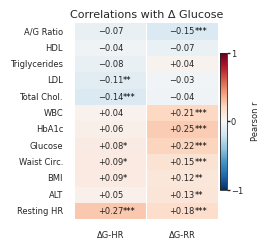

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import pdist

# --- rename the two CF columns for clarity in the inputs (if needed) ---
merged_data = merged_data.rename(columns={
    'min_value_HR': 'Δ Glucose via HR',
    'min_value_RR': 'Δ Glucose via RR'
})

correlation_columns = [
    'Δ Glucose via HR', 'Δ Glucose via RR',
    'HDL Cholesterol (mg/dL)', 'Triglycerides (mg/dL)',
    'HbA1c (%)', 'pulse_vsorres, Heart Rate (bpm)',
    'Glucose (mg/dL)', 'Total Cholesterol (mg/dL)',
    'bmi_vsorres, BMI', 'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL',
    'waist_vsorres, Waist Circumference (cm)',
    'A/G Ratio', 'ALT (IU/L)',
    'LDL Cholesterol Calculation (mg/dL)'
]

# ---------- compute pairwise r, p ----------
X = merged_data[correlation_columns].apply(pd.to_numeric, errors='coerce')

def pairwise_corr_p(df):
    cols = df.columns
    rmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    pmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    nmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    for i, ci in enumerate(cols):
        xi = df[ci]
        for j, cj in enumerate(cols):
            xj = df[cj]
            mask = xi.notna() & xj.notna()
            n = int(mask.sum())
            if n >= 3 and xi[mask].nunique() > 1 and xj[mask].nunique() > 1:
                r, p = pearsonr(xi[mask], xj[mask])
                rmat.iloc[i, j] = r
                pmat.iloc[i, j] = p
                nmat.iloc[i, j] = n
    return rmat, pmat, nmat

df_corr, df_pval, df_n = pairwise_corr_p(X)

# ---------- define focus and CLUSTERED row order ----------
focus = ['Δ Glucose via HR', 'Δ Glucose via RR']
phenos = [c for c in df_corr.columns if c not in focus]

# matrix for clustering (phenotypes × 2). z-score columns first; fillna only for ordering.
cluster_block = df_corr.loc[phenos, focus].astype(float)
Z = (cluster_block - cluster_block.mean()) / cluster_block.std(ddof=0)
Z = Z.fillna(0.0)

# hierarchical clustering with optimal leaf ordering (keeps small panel tidy)
d = pdist(Z.values, metric='euclidean')
L = linkage(d, method='average')
L_opt = optimal_leaf_ordering(L, d)
row_order = cluster_block.index[leaves_list(L_opt)].tolist()

# ---------- MULTIPLE-TESTING CORRECTION BEFORE SUBSETTING ----------
FDR_METHOD = 'fdr_bh'  # Benjamini–Hochberg
def fdr_over_phenotype_vs_focus(p_all, phenos, focus, method='fdr_bh'):
    block = p_all.loc[phenos, focus]
    flat = block.to_numpy().ravel()
    mask = ~np.isnan(flat)
    adj = np.full_like(flat, np.nan, dtype=float)
    if mask.any():
        adj[mask] = multipletests(flat[mask], method=method)[1]
    return pd.DataFrame(adj.reshape(block.shape), index=block.index, columns=block.columns)

q_all = fdr_over_phenotype_vs_focus(df_pval, phenos, focus, method=FDR_METHOD)

# ---------- subset AFTER adjustment ----------
r_sub = df_corr.loc[row_order, focus].copy()
q_sub = q_all.loc[row_order, focus].copy()

# ---------- labels ----------
rename = {
    'Δ Glucose via HR': 'ΔG-HR',
    'Δ Glucose via RR': 'ΔG-RR',
    'HDL Cholesterol (mg/dL)': 'HDL',
    'Triglycerides (mg/dL)': 'Triglycerides',
    'A/G Ratio': 'A/G Ratio',
    'ALT (IU/L)': 'ALT',
    'HbA1c (%)': 'HbA1c',
    'pulse_vsorres, Heart Rate (bpm)': 'Resting HR',
    'Glucose (mg/dL)': 'Glucose',
    'Total Cholesterol (mg/dL)': 'Total Chol.',
    "bmi_vsorres, BMI": "BMI",
    'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL': "WBC",
    'waist_vsorres, Waist Circumference (cm)': "Waist Circ.",
    'LDL Cholesterol Calculation (mg/dL)': 'LDL',
}
r_sub = r_sub.rename(index=rename, columns=rename)
q_sub = q_sub.rename(index=rename, columns=rename)
r_sub = r_sub[['ΔG-HR', 'ΔG-RR']]
q_sub = q_sub[['ΔG-HR', 'ΔG-RR']]

# ---------- formatting helpers ----------
MINUS = "\u2212"
def fmt_signed(x):
    if pd.isna(x): return ""
    return f"+{abs(x):.2f}" if x >= 0 else f"{MINUS}{abs(x):.2f}"

def star_str(q):
    if pd.isna(q): return ""
    return "***" if q < 1e-3 else ("**" if q < 1e-2 else ("*" if q < 5e-2 else ""))

annot_numbers = r_sub.applymap(fmt_signed)
stars_grid = q_sub.applymap(star_str)

# ---------- plot ----------
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":7, "axes.titlesize":8, "axes.labelsize":7,
                             "xtick.labelsize":6, "ytick.labelsize":6})

fig, ax = plt.subplots(figsize=(2.6, 2.4))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

hm = sns.heatmap(
    r_sub, annot=annot_numbers, fmt="",
    cmap="RdBu_r", norm=norm, linewidths=0,
    cbar=True, cbar_kws={"fraction":0.045, "pad":0.01},
    square=False, annot_kws={"ha":"center", "va":"center", "fontsize":6}
)

ax.set_xlabel(""); ax.set_ylabel("")
ax.set_title("Correlations with Δ Glucose", pad=4)
plt.xticks(rotation=0); plt.yticks(rotation=0)

# single column separator
ymin, ymax = ax.get_ylim()
ax.vlines(1, ymin, ymax, colors="white", linewidth=0.8)
for s in ax.spines.values(): s.set_visible(False)

cbar = hm.collections[0].colorbar
cbar.set_ticks([-1, 0, 1])
cbar.set_label("Pearson r", rotation=90, labelpad=6, fontsize=6)
cbar.ax.tick_params(labelsize=6, length=2, pad=1)
cbar.outline.set_linewidth(0.6)

# contrast tweak
threshold = 0.35
n_cols = r_sub.shape[1]
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        val = r_sub.loc[row, col]
        txt = hm.texts[y * n_cols + x]
        if abs(val) >= threshold:
            txt.set_color("white"); txt.set_fontweight("semibold")

# overlay stars to the right of numbers
x_dx = 0.17
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        s = stars_grid.loc[row, col]
        if s:
            star_color = "white" if abs(r_sub.loc[row, col]) >= threshold else "black"
            ax.text(x + 0.5 + x_dx, y + 0.5, s,
                    ha="left", va="center", fontsize=6, color=star_color, clip_on=False, zorder=5)

plt.tight_layout(pad=0.5)
plt.savefig("./figures/heatmap_delta_glucose_corr.pdf", bbox_inches="tight")
plt.savefig("./figures/heatmap_delta_glucose_corr.png", dpi=600, bbox_inches="tight")
plt.show()


/tmp/ipykernel_14291/1951123759.py:124: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_numbers = r_sub.applymap(fmt_signed)
/tmp/ipykernel_14291/1951123759.py:125: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stars_grid = q_sub.applymap(star_str)


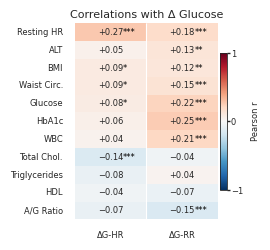

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import pdist

# --- rename the two CF columns for clarity in the inputs (if needed) ---
merged_data = merged_data.rename(columns={
    'min_value_HR': 'Δ Glucose via HR',
    'min_value_RR': 'Δ Glucose via RR'
})

correlation_columns = [
    'Δ Glucose via HR', 'Δ Glucose via RR',
    'HDL Cholesterol (mg/dL)', 'Triglycerides (mg/dL)',
    'HbA1c (%)', 'pulse_vsorres, Heart Rate (bpm)',
    'Glucose (mg/dL)', 'Total Cholesterol (mg/dL)',
    'bmi_vsorres, BMI', 'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL',
    'waist_vsorres, Waist Circumference (cm)',
    'A/G Ratio', 'ALT (IU/L)'
]

# ---------- compute pairwise r, p ----------
X = merged_data[correlation_columns].apply(pd.to_numeric, errors='coerce')

def pairwise_corr_p(df):
    cols = df.columns
    rmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    pmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    nmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    for i, ci in enumerate(cols):
        xi = df[ci]
        for j, cj in enumerate(cols):
            xj = df[cj]
            mask = xi.notna() & xj.notna()
            n = int(mask.sum())
            if n >= 3 and xi[mask].nunique() > 1 and xj[mask].nunique() > 1:
                r, p = pearsonr(xi[mask], xj[mask])
                rmat.iloc[i, j] = r
                pmat.iloc[i, j] = p
                nmat.iloc[i, j] = n
    return rmat, pmat, nmat

df_corr, df_pval, df_n = pairwise_corr_p(X)

# ---------- define focus ----------
focus = ['Δ Glucose via HR', 'Δ Glucose via RR']
phenos = [c for c in df_corr.columns if c not in focus]

# matrix for clustering (phenotypes × 2). z-score columns first; fillna only for ordering.
cluster_block = df_corr.loc[phenos, focus].astype(float)
Z = (cluster_block - cluster_block.mean()) / cluster_block.std(ddof=0)
Z = Z.fillna(0.0)

# hierarchical clustering with optimal leaf ordering
d = pdist(Z.values, metric='euclidean')
L = linkage(d, method='average')
L_opt = optimal_leaf_ordering(L, d)
row_order = cluster_block.index[leaves_list(L_opt)].tolist()

# ---------- ORIENT rows so the positive block sits on top ----------
# Compare the mean of the top vs bottom chunk; flip if needed.
k = max(1, int(np.ceil(0.35 * len(row_order))))  # use ~top/bottom 35% as a "block"
means = cluster_block.loc[row_order].mean(axis=1)
if means.iloc[:k].mean() < means.iloc[-k:].mean():
    row_order = row_order[::-1]

# (Optional STRICT variant: place all positive-mean rows above negative ones,
# preserving clustered order within each group.)
# pos = [r for r in row_order if means.loc[r] >= 0]
# neg = [r for r in row_order if means.loc[r] < 0]
# row_order = pos + neg

# ---------- MULTIPLE-TESTING CORRECTION BEFORE SUBSETTING ----------
FDR_METHOD = 'fdr_bh'
def fdr_over_phenotype_vs_focus(p_all, phenos, focus, method='fdr_bh'):
    block = p_all.loc[phenos, focus]
    flat = block.to_numpy().ravel()
    mask = ~np.isnan(flat)
    adj = np.full_like(flat, np.nan, dtype=float)
    if mask.any():
        adj[mask] = multipletests(flat[mask], method=method)[1]
    return pd.DataFrame(adj.reshape(block.shape), index=block.index, columns=block.columns)

q_all = fdr_over_phenotype_vs_focus(df_pval, phenos, focus, method=FDR_METHOD)

# ---------- subset AFTER adjustment ----------
r_sub = df_corr.loc[row_order, focus].copy()
q_sub = q_all.loc[row_order, focus].copy()

# ---------- labels ----------
rename = {
    'Δ Glucose via HR': 'ΔG-HR',
    'Δ Glucose via RR': 'ΔG-RR',
    'HDL Cholesterol (mg/dL)': 'HDL',
    'Triglycerides (mg/dL)': 'Triglycerides',
    'A/G Ratio': 'A/G Ratio',
    'ALT (IU/L)': 'ALT',
    'HbA1c (%)': 'HbA1c',
    'pulse_vsorres, Heart Rate (bpm)': 'Resting HR',
    'Glucose (mg/dL)': 'Glucose',
    'Total Cholesterol (mg/dL)': 'Total Chol.',
    "bmi_vsorres, BMI": "BMI",
    'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL': "WBC",
    'waist_vsorres, Waist Circumference (cm)': "Waist Circ."
}
r_sub = r_sub.rename(index=rename, columns=rename)[['ΔG-HR', 'ΔG-RR']]
q_sub = q_sub.rename(index=rename, columns=rename)[['ΔG-HR', 'ΔG-RR']]

# ---------- formatting helpers ----------
MINUS = "\u2212"
def fmt_signed(x):
    if pd.isna(x): return ""
    return f"+{abs(x):.2f}" if x >= 0 else f"{MINUS}{abs(x):.2f}"

def star_str(q):
    if pd.isna(q): return ""
    return "***" if q < 1e-3 else ("**" if q < 1e-2 else ("*" if q < 5e-2 else ""))

annot_numbers = r_sub.applymap(fmt_signed)
stars_grid = q_sub.applymap(star_str)

# ---------- plot ----------
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":7, "axes.titlesize":8, "axes.labelsize":7,
                             "xtick.labelsize":6, "ytick.labelsize":6})

fig, ax = plt.subplots(figsize=(2.6, 2.4))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

hm = sns.heatmap(
    r_sub, annot=annot_numbers, fmt="",
    cmap="RdBu_r", norm=norm, linewidths=0,
    cbar=True, cbar_kws={"fraction":0.045, "pad":0.01},
    square=False, annot_kws={"ha":"center", "va":"center", "fontsize":6}
)

ax.set_xlabel(""); ax.set_ylabel("")
ax.set_title("Correlations with Δ Glucose", pad=4)
plt.xticks(rotation=0); plt.yticks(rotation=0)

# single column separator
ymin, ymax = ax.get_ylim()
ax.vlines(1, ymin, ymax, colors="white", linewidth=0.8)
for s in ax.spines.values(): s.set_visible(False)

cbar = hm.collections[0].colorbar
cbar.set_ticks([-1, 0, 1])
cbar.set_label("Pearson r", rotation=90, labelpad=6, fontsize=6)
cbar.ax.tick_params(labelsize=6, length=2, pad=1)
cbar.outline.set_linewidth(0.6)

# contrast tweak
threshold = 0.35
n_cols = r_sub.shape[1]
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        val = r_sub.loc[row, col]
        txt = hm.texts[y * n_cols + x]
        if abs(val) >= threshold:
            txt.set_color("white"); txt.set_fontweight("semibold")

# overlay stars to the right of numbers
x_dx = 0.17
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        s = stars_grid.loc[row, col]
        if s:
            star_color = "white" if abs(r_sub.loc[row, col]) >= threshold else "black"
            ax.text(x + 0.5 + x_dx, y + 0.5, s,
                    ha="left", va="center", fontsize=6, color=star_color, clip_on=False, zorder=5)

plt.tight_layout(pad=0.5)
plt.savefig("./figures/heatmap_delta_glucose_corr.pdf", bbox_inches="tight")
plt.savefig("./figures/heatmap_delta_glucose_corr.png", dpi=600, bbox_inches="tight")
plt.show()


# OLD PLOT VERSIONS

In [ ]:
# Rename min value columns for clarity
merged_data = merged_data.rename(columns={
    'min_value_HR': 'Δ Glucose via HR',
    'min_value_RR': 'Δ Glucose via RR'
})

# Plot correlation matrix for the following measures:
# ['HR','RR','HDL Cholesterol (mg/dL)', 'Triglycerides (mg/dL)', 'HbA1c (%)', 'pulse_vsorres, Heart Rate (bpm)', 'Glucose (mg/dL)', 'Total Cholesterol (mg/dL)']
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate correlations between counterfactuals and other clinical measures
correlation_columns = ['Δ Glucose via HR', 'Δ Glucose via RR', 'HDL Cholesterol (mg/dL)', 'Triglycerides (mg/dL)', 
                       'HbA1c (%)', 'pulse_vsorres, Heart Rate (bpm)', 'Glucose (mg/dL)', 
                       'Total Cholesterol (mg/dL)', "bmi_vsorres, BMI",
                       'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL',
                       'waist_vsorres, Waist Circumference (cm)'
                       ]


correlation_data = merged_data[correlation_columns].corr()
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Correlations between Counterfactuals and Clinical Measures')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("./figures/correlation_counterfactuals_clinical_measures.png", dpi=1000, bbox_inches="tight")
# plt.savefig("correlation_counterfactuals_clinical_measures.pdf", bbox_inches="tight")
plt.show()  

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# ensure numeric
X = merged_data[correlation_columns].apply(pd.to_numeric, errors='coerce')

def pairwise_corr_p(df):
    cols = df.columns
    rmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    pmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    nmat = pd.DataFrame(np.nan, index=cols, columns=cols)

    for i, ci in enumerate(cols):
        xi = df[ci]
        for j, cj in enumerate(cols):
            xj = df[cj]
            mask = xi.notna() & xj.notna()
            n = int(mask.sum())
            if n >= 3 and xi[mask].nunique() > 1 and xj[mask].nunique() > 1:
                r, p = pearsonr(xi[mask], xj[mask])
                rmat.iloc[i, j] = r
                pmat.iloc[i, j] = p
                nmat.iloc[i, j] = n
    return rmat, pmat, nmat

df_corr, df_pval, df_n = pairwise_corr_p(X)


def stars(p):
    if pd.isna(p): return ''
    return '***' if p < 1e-3 else '**' if p < 1e-2 else '*' if p < 5e-2 else ''

annot = df_corr.round(2).astype(str) + "\n" + df_pval.apply(lambda s: s.map(stars))


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=annot, fmt='', cmap='coolwarm', vmin=-1, vmax=1,
            square=True, cbar_kws={"shrink": .8})
plt.title('Correlations between Counterfactuals and Clinical Measures')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("./figures/correlation_counterfactuals_clinical_measures_sig.png", dpi=1000, bbox_inches="tight")
plt.show()

focus = ['Δ Glucose via HR', 'Δ Glucose via RR']
others = [c for c in correlation_columns if c not in focus]
rows = []
for f in focus:
    for o in others:
        r = df_corr.loc[f, o]
        p = df_pval.loc[f, o]
        n = df_n.loc[f, o]
        rows.append({'counterfactual': f, 'phenotype': o, 'r': r, 'p': p, 'n': n, 'sig': stars(p)})
summary = pd.DataFrame(rows).sort_values(['counterfactual', 'p'])
print(summary)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import pearsonr

# ensure numeric
X = merged_data[correlation_columns].apply(pd.to_numeric, errors='coerce')

def pairwise_corr_p(df):
    cols = df.columns
    rmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    pmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    nmat = pd.DataFrame(np.nan, index=cols, columns=cols)

    for i, ci in enumerate(cols):
        xi = df[ci]
        for j, cj in enumerate(cols):
            xj = df[cj]
            mask = xi.notna() & xj.notna()
            n = int(mask.sum())
            if n >= 3 and xi[mask].nunique() > 1 and xj[mask].nunique() > 1:
                r, p = pearsonr(xi[mask], xj[mask])
                rmat.iloc[i, j] = r
                pmat.iloc[i, j] = p
                nmat.iloc[i, j] = n
    return rmat, pmat, nmat

df_corr, df_pval, df_n = pairwise_corr_p(X)

# -----------------------
# Inputs assumed available
# -----------------------
# df_corr : DataFrame of correlation coefficients (rows = phenotypes, cols include the two "focus" vars)
# df_pval : DataFrame of corresponding p-values (same shape)

# --- pick the two focus variables ---
focus = ['Δ Glucose via HR', 'Δ Glucose via RR']

# phenotypes = everything except the focus vars
phenos = [c for c in df_corr.columns if c not in focus]

# order rows (phenotypes) by mean absolute correlation with the focus cols
row_order = (
    df_corr.loc[phenos, focus]
    .abs().mean(axis=1)
    .sort_values(ascending=False)
    .index.tolist()
)

# submatrices for r and p
r_sub = df_corr.loc[row_order, focus].copy()
p_sub = df_pval.loc[row_order, focus].copy()

# ---------------------------
# Optional: shorten labels
# ---------------------------
rename = {
    'Δ Glucose via HR': 'ΔG-HR',
    'Δ Glucose via RR': 'ΔG-RR',
    'HDL Cholesterol (mg/dL)': 'HDL',
    'Triglycerides (mg/dL)': 'Triglycerides',
    'HbA1c (%)': 'HbA1c',
    'pulse_vsorres, Heart Rate (bpm)': 'Heart Rate',
    'Glucose (mg/dL)': 'Glucose',
    'Total Cholesterol (mg/dL)': 'Total Chol.',
    "bmi_vsorres, BMI": "BMI",
    'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL': "WBC",
    'waist_vsorres, Waist Circumference (cm)': "Waist Circ."
}
r_sub = r_sub.rename(index=rename, columns=rename)
p_sub = p_sub.rename(index=rename, columns=rename)

# keep preferred column order
col_order = ['ΔG-HR', 'ΔG-RR']
r_sub = r_sub[col_order]
p_sub = p_sub[col_order]

# ---------------------------
# Formatting helpers
# ---------------------------
MINUS = "\u2212"  # true minus sign (looks same "size" as +)
def fmt_signed(x: float) -> str:
    if pd.isna(x): return ""
    return f"+{abs(x):.2f}" if x >= 0 else f"{MINUS}{abs(x):.2f}"

def star_str(p):
    if pd.isna(p): return ""
    return "***" if p < 1e-3 else ("**" if p < 1e-2 else ("*" if p < 5e-2 else ""))

# numbers-only annotations (stay centered)
annot_numbers = r_sub.applymap(fmt_signed)
# stars grid (overlay later)
stars_grid = p_sub.applymap(star_str)

# ---------------------------
# Plot
# ---------------------------
sns.set_theme(style="white")
sns.set_context("paper", rc={
    "font.size":7, "axes.titlesize":8, "axes.labelsize":7,
    "xtick.labelsize":6, "ytick.labelsize":6
})

fig, ax = plt.subplots(figsize=(2.7, 2.8))

# Diverging map centered at 0
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

hm = sns.heatmap(
    r_sub,
    annot=annot_numbers, fmt="",
    cmap="RdBu_r", norm=norm,
    linewidths=0.0,
    cbar=True, cbar_kws={"fraction":0.045, "pad":0.01},
    square=False,
    annot_kws={"ha":"center", "va":"center", "fontsize":6}
)

# Titles/labels
ax.set_xlabel(""); ax.set_ylabel("")
ax.set_title("Correlations with Δ Glucose", pad=4)
plt.xticks(rotation=0); plt.yticks(rotation=0)

# Single separator between columns
ymin, ymax = ax.get_ylim()
ax.vlines(1, ymin, ymax, colors="white", linewidth=0.8)

# No frame
for spine in ax.spines.values():
    spine.set_visible(False)

# Compact colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-1, 0, 1])
cbar.set_label("Pearson r", rotation=90, labelpad=6, fontsize=6)
cbar.ax.tick_params(labelsize=6, length=2, pad=1)
cbar.outline.set_linewidth(0.6)

# Improve contrast of numbers on strong colors
threshold = 0.35
n_cols = r_sub.shape[1]
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        val = r_sub.loc[row, col]
        txt = hm.texts[y * n_cols + x]  # text artist for that cell
        if abs(val) >= threshold:
            txt.set_color("white")
            txt.set_fontweight("semibold")

# Overlay stars to the RIGHT of the centered number (not affecting centering)
x_dx = 0.16
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        s = stars_grid.loc[row, col]
        if s:
            # match color to number contrast for readability
            star_color = "white" if abs(r_sub.loc[row, col]) >= threshold else "black"
            ax.text(
                x + 0.5 + x_dx, y + 0.5,
                s, ha="left", va="center",
                fontsize=6, color=star_color, clip_on=False, zorder=5
            )

plt.tight_layout(pad=0.5)

# Exports
plt.savefig("./figures/heatmap_delta_glucose_corr.pdf", bbox_inches="tight")
plt.savefig("./figures/heatmap_delta_glucose_corr.png", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests  # <— NEW

# ensure numeric
X = merged_data[correlation_columns].apply(pd.to_numeric, errors='coerce')

def pairwise_corr_p(df):
    cols = df.columns
    rmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    pmat = pd.DataFrame(np.nan, index=cols, columns=cols)
    nmat = pd.DataFrame(np.nan, index=cols, columns=cols)

    for i, ci in enumerate(cols):
        xi = df[ci]
        for j, cj in enumerate(cols):
            xj = df[cj]
            mask = xi.notna() & xj.notna()
            n = int(mask.sum())
            if n >= 3 and xi[mask].nunique() > 1 and xj[mask].nunique() > 1:
                r, p = pearsonr(xi[mask], xj[mask])
                rmat.iloc[i, j] = r
                pmat.iloc[i, j] = p
                nmat.iloc[i, j] = n
    return rmat, pmat, nmat

df_corr, df_pval, df_n = pairwise_corr_p(X)

# --- pick the two focus variables ---
focus = ['Δ Glucose via HR', 'Δ Glucose via RR']
phenos = [c for c in df_corr.columns if c not in focus]

row_order = (
    df_corr.loc[phenos, focus]
    .abs().mean(axis=1).sort_values(ascending=False).index.tolist()
)

# submatrices for r and p
r_sub = df_corr.loc[row_order, focus].copy()
p_sub = df_pval.loc[row_order, focus].copy()

# ---------------------------
# OPTIONAL: shorten labels
# ---------------------------
rename = {
    'Δ Glucose via HR': 'ΔG-HR',
    'Δ Glucose via RR': 'ΔG-RR',
    'HDL Cholesterol (mg/dL)': 'HDL',
    'Triglycerides (mg/dL)': 'Triglycerides',
    'HbA1c (%)': 'HbA1c',
    'pulse_vsorres, Heart Rate (bpm)': 'Resting HR',
    'Glucose (mg/dL)': 'Glucose',
    'Total Cholesterol (mg/dL)': 'Total Chol.',
    "bmi_vsorres, BMI": "BMI",
    'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL': "WBC",
    'waist_vsorres, Waist Circumference (cm)': "Waist Circ."
}
r_sub = r_sub.rename(index=rename, columns=rename)
p_sub = p_sub.rename(index=rename, columns=rename)

col_order = ['ΔG-HR', 'ΔG-RR']
r_sub = r_sub[col_order]
p_sub = p_sub[col_order]

# ---------------------------
# MULTIPLE-TESTING CORRECTION (FDR)
# ---------------------------
def adjust_pvals_df(p_df, method='fdr_bh'):
    """Return a DataFrame of adjusted p-values (q-values), keeping NaNs."""
    flat = p_df.to_numpy().ravel()
    mask = ~np.isnan(flat)
    q = np.full_like(flat, np.nan, dtype=float)
    if mask.sum() > 0:
        q[mask] = multipletests(flat[mask], method=method)[1]
    return pd.DataFrame(q.reshape(p_df.shape), index=p_df.index, columns=p_df.columns)

FDR_METHOD = 'fdr_bh'  # options: 'fdr_bh','bonferroni','holm','fdr_by', ...
q_sub = adjust_pvals_df(p_sub, method=FDR_METHOD)

# ---------------------------
# Formatting helpers
# ---------------------------
MINUS = "\u2212"  # true minus sign so + and − match visually
def fmt_signed(x: float) -> str:
    if pd.isna(x): return ""
    return f"+{abs(x):.2f}" if x >= 0 else f"{MINUS}{abs(x):.2f}"

def star_str(p_adj):
    """Stars based on ADJUSTED p (q-value)."""
    if pd.isna(p_adj): return ""
    return "***" if p_adj < 1e-3 else ("**" if p_adj < 1e-2 else ("*" if p_adj < 5e-2 else ""))

annot_numbers = r_sub.applymap(fmt_signed)
stars_grid = q_sub.applymap(star_str)   # <— use adjusted p-values

# ---------------------------
# Plot
# ---------------------------
sns.set_theme(style="white")
sns.set_context("paper", rc={
    "font.size":7, "axes.titlesize":8, "axes.labelsize":7,
    "xtick.labelsize":6, "ytick.labelsize":6
})

fig, ax = plt.subplots(figsize=(2.7, 2.8))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

hm = sns.heatmap(
    r_sub,
    annot=annot_numbers, fmt="",
    cmap="RdBu_r", norm=norm,
    linewidths=0.0,
    cbar=True, cbar_kws={"fraction":0.045, "pad":0.01},
    square=False,
    annot_kws={"ha":"center", "va":"center", "fontsize":6}
)

ax.set_xlabel(""); ax.set_ylabel("")
ax.set_title("Correlations with Δ Glucose", pad=4)
plt.xticks(rotation=0); plt.yticks(rotation=0)

# one separator between columns
ymin, ymax = ax.get_ylim()
ax.vlines(1, ymin, ymax, colors="white", linewidth=0.8)

# remove frame
for s in ax.spines.values():
    s.set_visible(False)

# compact colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-1, 0, 1])
cbar.set_label("Pearson r", rotation=90, labelpad=6, fontsize=6)
cbar.ax.tick_params(labelsize=6, length=2, pad=1)
cbar.outline.set_linewidth(0.6)

# improve contrast of numbers on strong colors
threshold = 0.35
n_cols = r_sub.shape[1]
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        val = r_sub.loc[row, col]
        txt = hm.texts[y * n_cols + x]
        if abs(val) >= threshold:
            txt.set_color("white"); txt.set_fontweight("semibold")

# overlay stars to the right of centered numbers
x_dx = 0.16
for y, row in enumerate(r_sub.index):
    for x, col in enumerate(r_sub.columns):
        s = stars_grid.loc[row, col]
        if s:
            star_color = "white" if abs(r_sub.loc[row, col]) >= threshold else "black"
            ax.text(x + 0.5 + x_dx, y + 0.5, s,
                    ha="left", va="center", fontsize=6, color=star_color, clip_on=False, zorder=5)

plt.tight_layout(pad=0.5)
plt.savefig("./figures/heatmap_delta_glucose_corr.pdf", bbox_inches="tight")
plt.savefig("./figures/heatmap_delta_glucose_corr.png", dpi=600, bbox_inches="tight")
plt.show()

# ADD COMMENT in Caption that the Correlation between DeltaG-HR and DeltaG-RR is 0.01, 
# indicating that the two counterfactuals are not correlated.

# OLD STUFF BELOW

In [ ]:
# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import f_oneway

CFvoi['study_group'] = CFvoi['study_group'].replace({
    'healthy': 'Healthy',
    'pre_diabetes_lifestyle_controlled': 'Pre-diabetes',
    'oral_medication_and_or_non_insulin_injectable_medication_controlled': 'Diabetes - Oral',
    'insulin_dependent': 'Diabetes - Insulin'
})

# Calculate mean and confidence intervals for each study group
import scipy.stats as stats

group_stats = CFvoi.groupby('study_group')['min_value'].agg(['mean', 'count', 'std'])
group_stats['sem'] = group_stats['std'] / group_stats['count']**0.5
group_stats['ci_lower'] = group_stats['mean'] - 1.96 * group_stats['sem']
group_stats['ci_upper'] = group_stats['mean'] + 1.96 * group_stats['sem']
group_stats = group_stats.sort_values('mean')

# One-way ANOVA to compare means across study groups

# Prepare the data for ANOVA
groups = [CFvoi[['study_group'] == g]['min_value'].dropna() for g in group_stats.index]
anova_stat, anova_pval = f_oneway(*groups)

# Forest plot (same as before)
plt.figure(figsize=(8, 6))
y_pos = range(len(group_stats))
plt.errorbar(group_stats['mean'], y_pos, xerr=[group_stats['mean']-group_stats['ci_lower'], group_stats['ci_upper']-group_stats['mean']],
             fmt='o', color='darkblue', ecolor='gray', capsize=5)
plt.yticks(y_pos, group_stats.index)
plt.xlabel('Δ Glucose (mg/dL)')
plt.title('Counterfactual: Δ Glucose (mg/dL) via 2-SD increase in Heart Rate by Study Group\n(with 95% CI)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("ANOVA p-value (across all study groups):", anova_pval)

KeyError: 'Column not found: min_value'

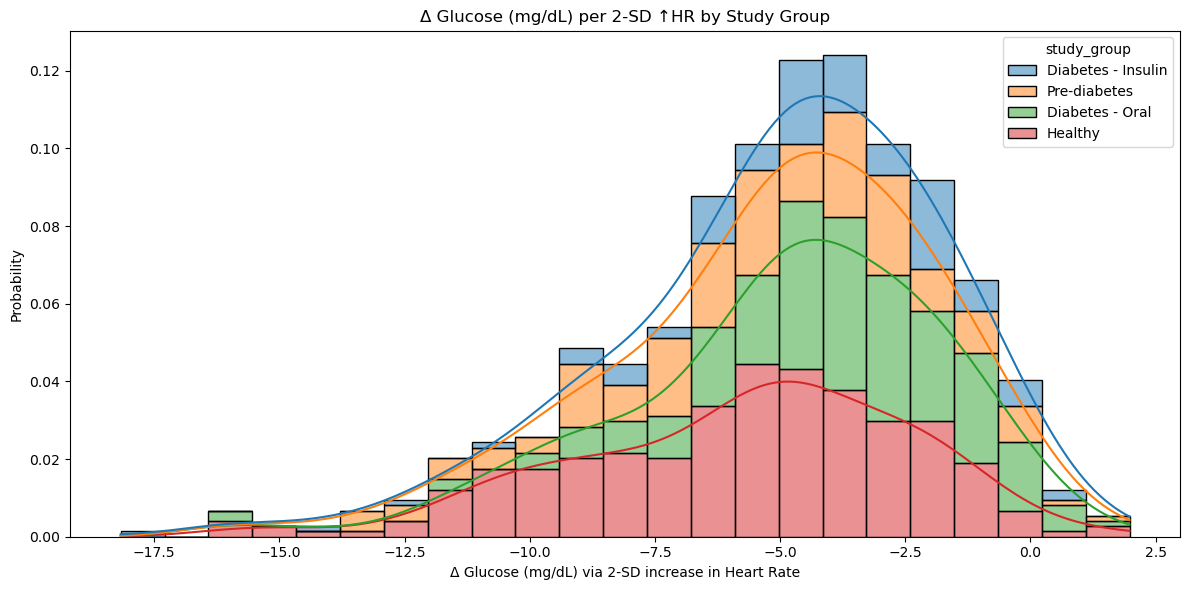

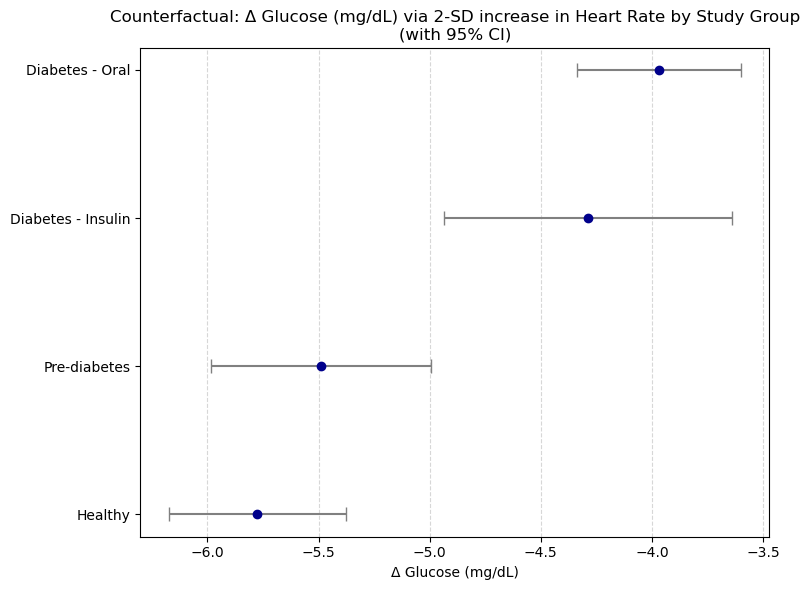

ANOVA p-value (across all study groups): 4.1191997e-10


In [17]:
# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import f_oneway


# Plot as distribution colored by study group - normalize the y axis
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_min_values,
    x='min_value',
    hue='study_group',
    multiple='stack',
    kde=True,
    stat='probability'  # This makes the y-axis a probability distribution
)
plt.title('Δ Glucose (mg/dL) per 2-SD ↑HR by Study Group')
plt.xlabel('Δ Glucose (mg/dL) via 2-SD increase in Heart Rate')
plt.ylabel('Probability')
#plt.legend(title='Study Group')
plt.tight_layout()
plt.show()


# Plot average effect and CI (or standard error) for each study group using df_min_values
# Order the study groups by their average minimum value
# Have it renamed (Healthy, Pre-diabetes, Diabetes - Oral, Diabetes - Insulin)
df_min_values['study_group'] = df_min_values['study_group'].replace({
    'healthy': 'Healthy',
    'pre_diabetes_lifestyle_controlled': 'Pre-diabetes',
    'oral_medication_and_or_non_insulin_injectable_medication_controlled': 'Diabetes - Oral',
    'insulin_dependent': 'Diabetes - Insulin'
})

# Calculate mean and confidence intervals for each study group
import scipy.stats as stats

group_stats = df_min_values.groupby('study_group')['min_value'].agg(['mean', 'count', 'std'])
group_stats['sem'] = group_stats['std'] / group_stats['count']**0.5
group_stats['ci_lower'] = group_stats['mean'] - 1.96 * group_stats['sem']
group_stats['ci_upper'] = group_stats['mean'] + 1.96 * group_stats['sem']
group_stats = group_stats.sort_values('mean')

# One-way ANOVA to compare means across study groups

# Prepare the data for ANOVA
groups = [df_min_values[df_min_values['study_group'] == g]['min_value'].dropna() for g in group_stats.index]
anova_stat, anova_pval = f_oneway(*groups)

# Forest plot (same as before)
plt.figure(figsize=(8, 6))
y_pos = range(len(group_stats))
plt.errorbar(group_stats['mean'], y_pos, xerr=[group_stats['mean']-group_stats['ci_lower'], group_stats['ci_upper']-group_stats['mean']],
             fmt='o', color='darkblue', ecolor='gray', capsize=5)
plt.yticks(y_pos, group_stats.index)
plt.xlabel('Δ Glucose (mg/dL)')
plt.title('Counterfactual: Δ Glucose (mg/dL) via 2-SD increase in Heart Rate by Study Group\n(with 95% CI)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("ANOVA p-value (across all study groups):", anova_pval)


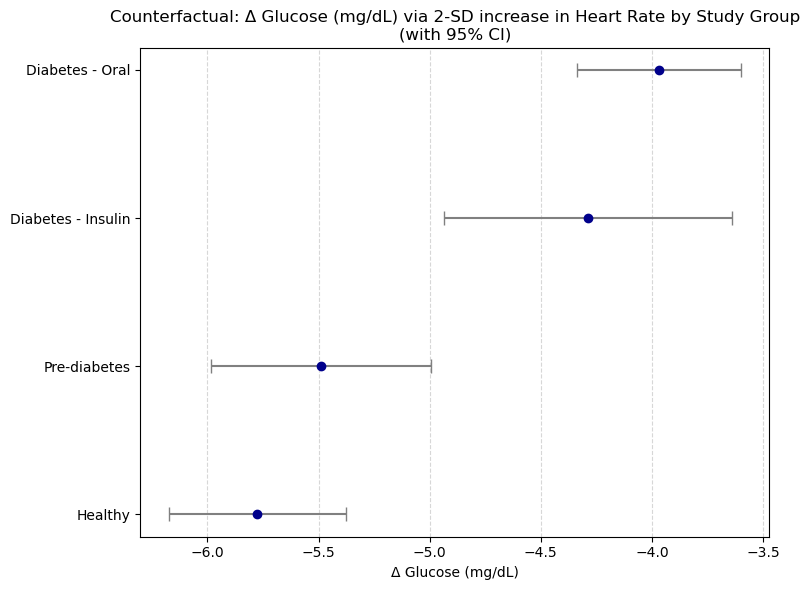

In [19]:
# Calculate mean and confidence intervals for each study group
import scipy.stats as stats

group_stats = df_min_values.groupby('study_group')['min_value'].agg(['mean', 'count', 'std'])
group_stats['sem'] = group_stats['std'] / group_stats['count']**0.5
group_stats['ci_lower'] = group_stats['mean'] - 1.96 * group_stats['sem']
group_stats['ci_upper'] = group_stats['mean'] + 1.96 * group_stats['sem']
group_stats = group_stats.sort_values('mean')

# Forest plot
plt.figure(figsize=(8, 6))
y_pos = range(len(group_stats))
plt.errorbar(group_stats['mean'], y_pos, xerr=[group_stats['mean']-group_stats['ci_lower'], group_stats['ci_upper']-group_stats['mean']],
             fmt='o', color='darkblue', ecolor='gray', capsize=5)
plt.yticks(y_pos, group_stats.index)
plt.xlabel('Δ Glucose (mg/dL)')
plt.title('Counterfactual: Δ Glucose (mg/dL) via 2-SD increase in Heart Rate by Study Group\n(with 95% CI)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [20]:
import pandas as pd

# 1) Align the key column name and dtype
#measurement_wide = measurement_wide.rename(columns={'person_id': 'participant_id'})
measurement_wide['participant_id'] = measurement_wide['participant_id'].astype('category')

# 2) Bring the index of df_min_values out as a column named participant_id
df_min_values = df_min_values.rename_axis('participant_id').reset_index()
df_min_values['participant_id'] = df_min_values['participant_id'].astype(str)

# 3) Make sure measurement_wide participant_id is also string-categorical (safe for merge)
measurement_wide['participant_id'] = measurement_wide['participant_id'].astype(str).astype('category')

# Sanity check: no duplicates
assert not measurement_wide['participant_id'].duplicated().any(), \
       "measurement_wide has duplicate participant_id values"
assert not df_min_values['participant_id'].duplicated().any(), \
       "df_min_values has duplicate participant_id values"

# 5) Merge
merged = pd.merge(
    measurement_wide,
    df_min_values,
    on='participant_id',
    how='inner',            # or 'inner' if you only want overlapping ids
    validate='one_to_one'  # change/remove if not one-to-one
)


In [15]:
# # Merge with measurement_wide (rename person_id to participant_id and make it a categorical) then merge directly on participant_id
# # Rename the index column to participant_id
# measurement_wide = measurement_wide.rename(columns={'person_id': 'participant_id'})
# df_min_values['participant_id'] = df_min_values.index

# #make sure participant_id is a string:
# measurement_wide['participant_id'] = measurement_wide['participant_id'].astype(str)
# df_min_values['participant_id'] = df_min_values['participant_id'].astype(str)

# df_min_values = df_min_values.reset_index(drop=True)
# measurement_wide = measurement_wide.reset_index(drop=True)

In [16]:

# print(measurement_wide)

In [17]:
# print(df_min_values)

In [18]:
# # Find duplicate participant_ids in measurement_wide
# duplicates_measurement_wide = measurement_wide['participant_id'][measurement_wide['participant_id'].duplicated()]
# print("Duplicate participant_ids in measurement_wide:")
# print(duplicates_measurement_wide)

# # Find duplicate participant_ids in df_min_values
# duplicates_df_min_values = df_min_values['participant_id'][df_min_values['participant_id'].duplicated()]
# print("Duplicate participant_ids in df_min_values:")
# print(duplicates_df_min_values)


In [ ]:
# # Merge with measurement_wide (rename person_id to participant_id and make it a categorical) then merge directly on participant_id
# # Rename the index column to participant_id
# measurement_wide = measurement_wide.rename(columns={'person_id': 'participant_id'})
# df_min_values['participant_id'] = df_min_values.index

# #make sure participant_id is a string:
# measurement_wide['participant_id'] = measurement_wide['participant_id'].astype(str)
# df_min_values['participant_id'] = df_min_values['participant_id'].astype(str)

# df_min_values = df_min_values.reset_index(drop=True)
# measurement_wide = measurement_wide.reset_index(drop=True)

In [21]:
CF_clin = merged

In [22]:
CF_clin

,participant_id,A/G Ratio,ALT (IU/L),AST (IU/L),Albumin (g/dL),Alkaline Phosphatase (IU/L),BUN (mg/dL),BUN/Creatinine ratio,"Bilirubin, Total (mg/dL)",C-Peptide (ng/mL),...,"viaosmsf, Snellen fraction - Mesopic VA - OS","viaosplog, VA Letter Score - Photopic VA - OS","viaospscore, Photopic LogMAR OS Score","viaospsf, Snellen fraction - Photopic VA - OS","viaossph, OS - Autorefractor - Sphere","waist_vsorres, Waist Circumference (cm)","weight_vsorres, Weight (kilograms)","whr_vsorres, Waist to Hip Ratio (WHR)",min_value,study_group
0,1023,2.333333,37.0,23.0,4.2,137.0,24.0,18.897638,0.6,1.681185,...,40.0,83.0,0.04,25.0,-0.25,117.6,91.7,1.110482,-0.366218,Diabetes - Insulin
1,1024,1.769231,9.0,15.0,4.6,63.0,21.0,21.649485,0.4,3.734425,...,63.0,78.0,0.14,32.0,-2.50,80.1,57.7,0.877327,-2.669307,Pre-diabetes
2,1026,1.909091,12.0,16.0,4.2,65.0,18.0,31.034483,0.7,1.676769,...,160.0,54.0,0.62,80.0,1.50,68.6,48.5,0.775141,-7.312077,Pre-diabetes
3,1027,1.500000,35.0,31.0,4.2,101.0,16.0,14.953271,0.8,1.993127,...,40.0,84.0,0.02,20.0,-2.25,103.2,86.6,1.003891,-9.020710,Diabetes - Oral
4,1028,1.740741,20.0,18.0,4.7,74.0,16.0,20.512821,0.3,2.566732,...,40.0,83.0,0.04,25.0,-0.50,89.8,63.9,0.963519,-9.470850,Diabetes - Oral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,7405,1.592593,14.0,20.0,4.3,59.0,28.0,17.391304,0.6,3.010000,...,40.0,82.0,0.06,25.0,0.00,111.1,98.0,0.970306,-0.850099,Diabetes - Oral
737,7406,1.281250,26.0,23.0,4.1,39.0,7.0,11.666667,0.4,3.090000,...,20.0,95.0,-0.20,12.0,-1.50,114.0,90.1,0.982759,-3.782544,Diabetes - Oral
738,7407,1.535714,14.0,15.0,4.3,91.0,10.0,9.900990,0.7,2.950000,...,40.0,86.0,-0.02,20.0,-1.75,99.6,80.5,0.966052,-7.050296,Diabetes - Oral
739,7409,1.840000,25.0,17.0,4.6,55.0,9.0,10.588235,0.7,1.750000,...,20.0,94.0,-0.18,12.0,-1.75,91.8,92.1,0.824798,-2.165680,Diabetes - Insulin


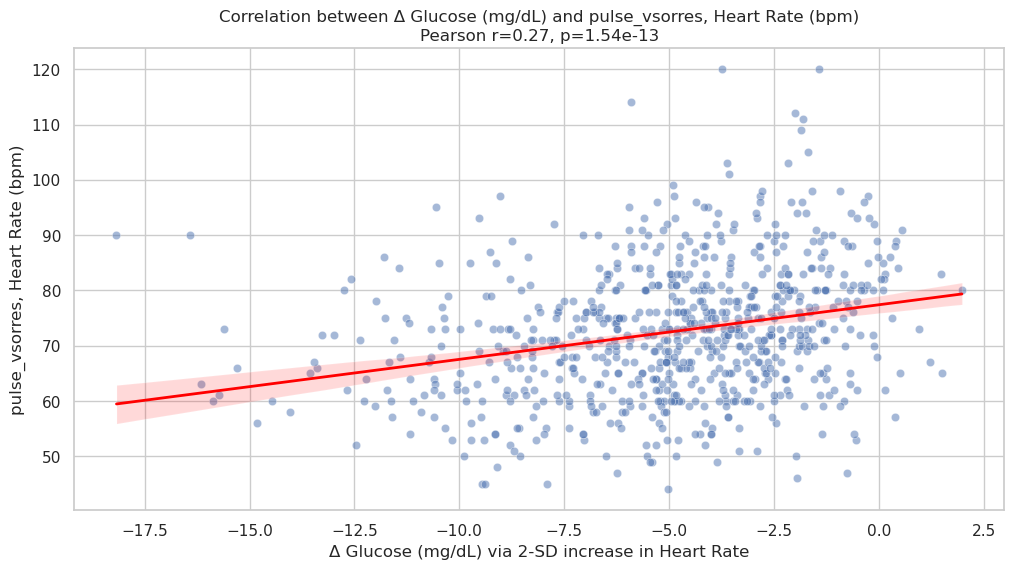

In [23]:
# Visualize regression and correlations and significance with min_value and HbA1c (%)
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 


#VOI = "HDL Cholesterol (mg/dL)"
#VOI = "Triglycerides (mg/dL)"
#VOI = 'HbA1c (%)'
VOI = 'pulse_vsorres, Heart Rate (bpm)'
#VOI = 'Glucose (mg/dL)'
#VOI = 'Total Cholesterol (mg/dL)'  # Example variable of interest

#Drop rows with NaN values in 'min_value' or VOI
CFvoi = CF_clin.dropna(subset=['min_value', VOI])

# Make sure both min_value and HbA1c (%) are numeric
CFvoi['min_value'] = pd.to_numeric(CFvoi['min_value'], errors='coerce')
CFvoi[VOI] = pd.to_numeric(CFvoi[VOI], errors='coerce')

# Set the style of seaborn
sns.set(style="whitegrid")
# Create a scatter plot with correlation and p-value significance:

plt.figure(figsize=(12, 6))
sns.scatterplot(x='min_value', y=VOI, data=CFvoi, alpha=0.5)
sns.regplot(x='min_value', y=VOI, data=CFvoi, scatter=False, color='red', line_kws={'lw':2})

# Calculate correlation and p-value
corr, pval = pearsonr(CFvoi['min_value'], CFvoi[VOI])
plt.title(f'Correlation between Δ Glucose (mg/dL) and {VOI}\nPearson r={corr:.2f}, p={pval:.2e}')
plt.xlabel('Δ Glucose (mg/dL) via 2-SD increase in Heart Rate')
plt.ylabel(VOI)
plt.show()

       HOMAIR  min_value
0    0.726096  -0.366218
1    0.225889  -2.669307
2    0.071688  -7.312077
3    0.394585  -9.020710
4    0.085704  -9.470850
..        ...        ...
736  0.235926  -0.850099
737  0.604938  -3.782544
738  0.192346  -7.050296
739  0.323457  -2.165680
740  0.083951  -0.119403

[718 rows x 2 columns]


/tmp/ipykernel_24435/3336004599.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CFvoi['min_value'] = pd.to_numeric(CFvoi['min_value'], errors='coerce')
/tmp/ipykernel_24435/3336004599.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CFvoi[VOI] = pd.to_numeric(CFvoi[VOI], errors='coerce')


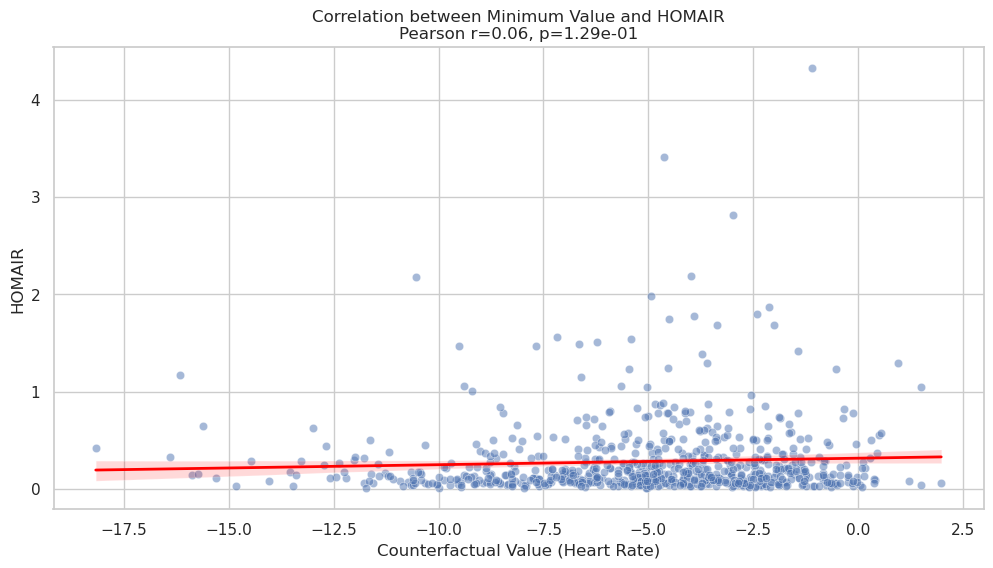

In [64]:
# Create a new column called IR_pred which is triglycerides over HDL
CF_clin['IR_pred'] = CF_clin['Triglycerides (mg/dL)'] / CF_clin['HDL Cholesterol (mg/dL)']
CF_clin['HOMAIR'] = (CF_clin['Glucose (mg/dL)'] * CF_clin['INSULIN (ng/mL)']) / 405
#CF_clin['HOMABETA'] = 8640 * CF_clin['INSULIN (ng/mL)'] / (CF_clin['Glucose (mg/dL)'] - 63)


#VOI = "IR_pred"
VOI = "HOMAIR"
#VOI = "HOMABETA"

#Drop rows with NaN values in 'min_value' or VOI
CFvoi = CF_clin.dropna(subset=['min_value', VOI])
print(CFvoi[[VOI, 'min_value']])

# Make sure both min_value and HbA1c (%) are numeric
CFvoi['min_value'] = pd.to_numeric(CFvoi['min_value'], errors='coerce')
CFvoi[VOI] = pd.to_numeric(CFvoi[VOI], errors='coerce')

# Set the style of seaborn
sns.set(style="whitegrid")
# Create a scatter plot with correlation and p-value significance:

plt.figure(figsize=(12, 6))
sns.scatterplot(x='min_value', y=VOI, data=CFvoi, alpha=0.5)
sns.regplot(x='min_value', y=VOI, data=CFvoi, scatter=False, color='red', line_kws={'lw':2})

# Calculate correlation and p-value
corr, pval = pearsonr(CFvoi['min_value'], CFvoi[VOI])
plt.title(f'Correlation between Minimum Value and {VOI}\nPearson r={corr:.2f}, p={pval:.2e}')
plt.xlabel('Counterfactual Value (Heart Rate)')
plt.ylabel(VOI)
plt.show()

/tmp/ipykernel_24435/4203920088.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CFvoi['min_value'] = pd.to_numeric(CFvoi['min_value'], errors='coerce')
/tmp/ipykernel_24435/4203920088.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CFvoi[VOI] = pd.to_numeric(CFvoi[VOI], errors='coerce')


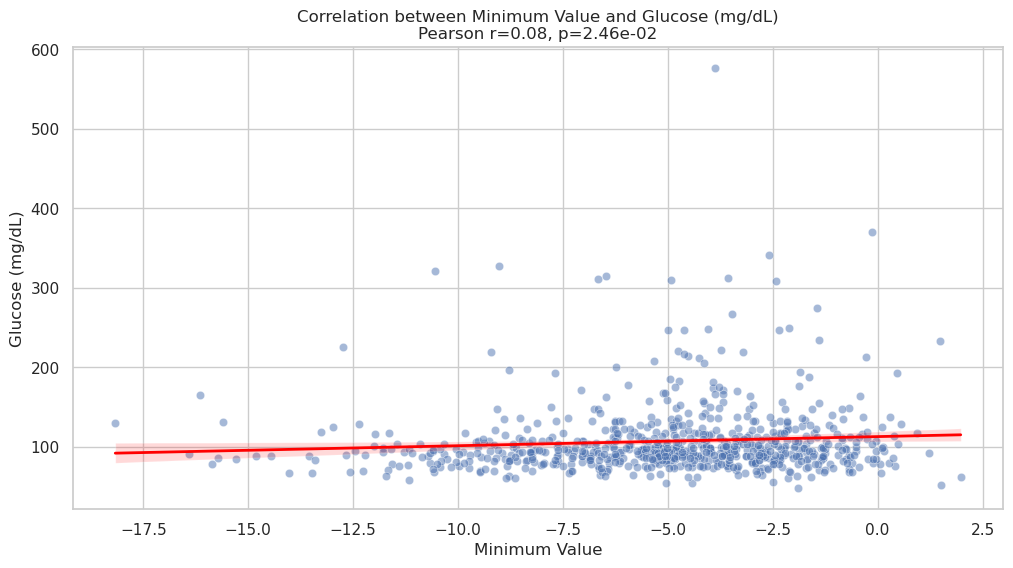

In [ ]:
# Visualize regression and correlations and significance with min_value and HbA1c (%)
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

VOI = 'Glucose (mg/dL)'

#Drop rows with NaN values in 'min_value' or VOI
CFvoi = CF_clin.dropna(subset=['min_value', VOI])

# Make sure both min_value and HbA1c (%) are numeric
CFvoi['min_value'] = pd.to_numeric(CFvoi['min_value'], errors='coerce')
CFvoi[VOI] = pd.to_numeric(CFvoi[VOI], errors='coerce')

# Set the style of seaborn
sns.set(style="whitegrid")
# Create a scatter plot with correlation and p-value significance:

plt.figure(figsize=(12, 6))
sns.scatterplot(x='min_value', y=VOI, data=CFvoi, alpha=0.5)
sns.regplot(x='min_value', y=VOI, data=CFvoi, scatter=False, color='red', line_kws={'lw':2})

# Calculate correlation and p-value
corr, pval = pearsonr(CFvoi['min_value'], CFvoi[VOI])
plt.title(f'Correlation between Minimum Value and {VOI}\nPearson r={corr:.2f}, p={pval:.2e}')
plt.xlabel('Minimum Value')
plt.ylabel(VOI)
plt.show()

In [ ]:
CF_clin['Bilirubin, Total (mg/dL)']

0      0.4
1      0.5
2      0.8
3      0.3
4      0.3
      ... 
736    0.3
737    0.3
738    0.9
739    0.3
740    0.2
Name: Bilirubin, Total (mg/dL), Length: 741, dtype: object

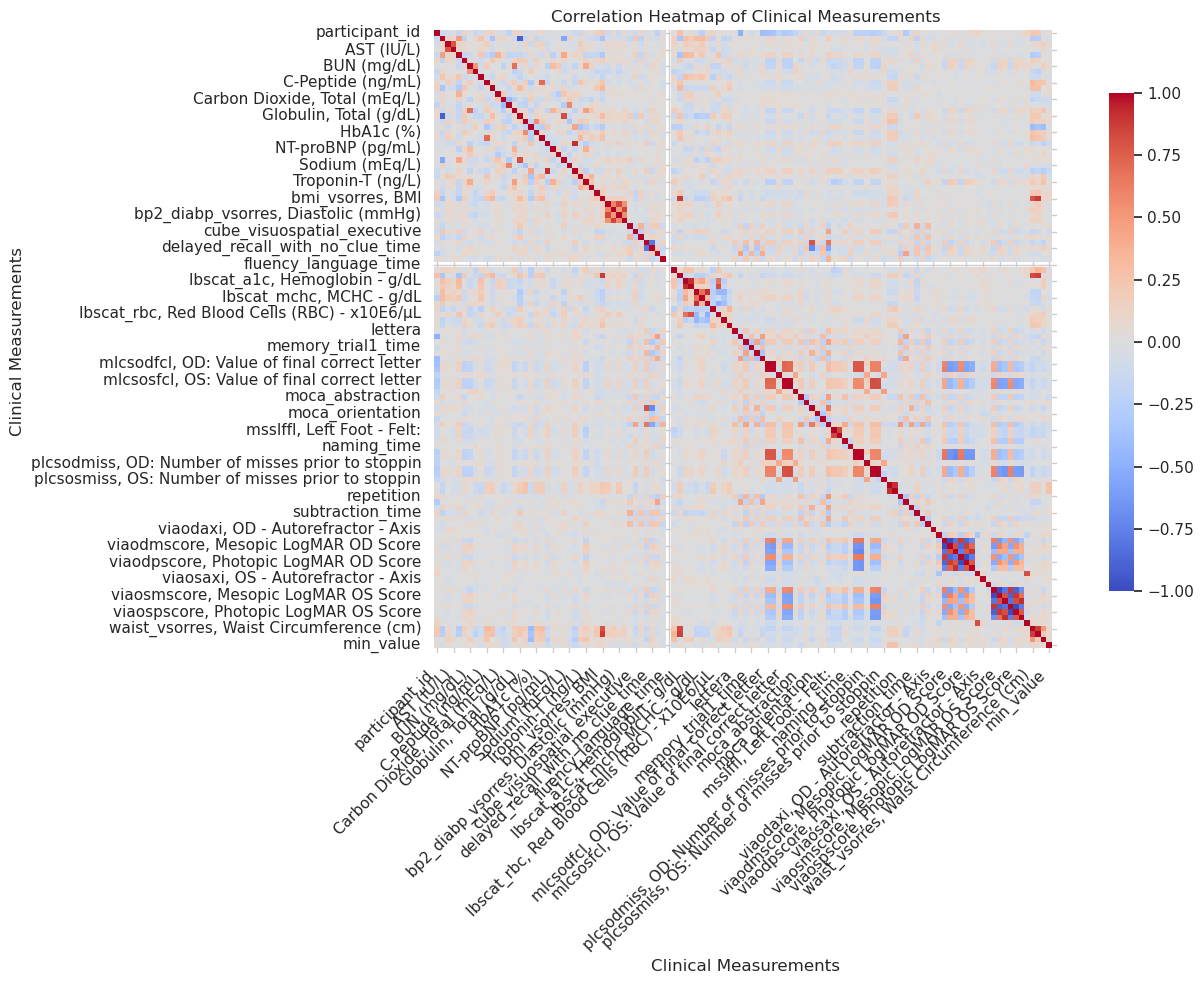

In [ ]:
# Show heatmap of correlations between min_value and other clinical measurements
plt.figure(figsize=(14, 10))

# Convert columns to numeric for all columns in CF_clin
CF_clin_numeric = CF_clin.copy() #CF_clin.select_dtypes(include=['number']).copy()
CF_clin_numeric = CF_clin_numeric.apply(pd.to_numeric, errors='coerce')

correlation_matrix = CF_clin_numeric.corr()
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Clinical Measurements')
plt.xlabel('Clinical Measurements')
plt.ylabel('Clinical Measurements')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Find highest correlations with min_value
min_value_corr = CF_clin_numeric.corr()['min_value'].sort_values(ascending=False)
print("Highest correlations with min_value:")
print(min_value_corr[min_value_corr.abs() > 0.5])  # Show only correlations above 0.5 or below -0.5
print("\nHighest correlations with min_value (absolute values):")       
print(min_value_corr.abs().sort_values(ascending=False).head(20))  # Show top 10 absolute correlations

# Find highest correlations with HbA1c (%)
hba1c_corr = CF_clin_numeric.corr()['HbA1c (%)'].sort_values(ascending=False)
print("\nHighest correlations with HbA1c (%):")
print(hba1c_corr[hba1c_corr.abs() > 0.5])
print("\nHighest correlations with HbA1c (%) (absolute values):")
print(hba1c_corr.abs().sort_values(ascending=False).head(20))   


Highest correlations with min_value:
min_value    1.0
Name: min_value, dtype: float64

Highest correlations with min_value (absolute values):
min_value                                       1.000000
pulse_vsorres, Heart Rate (bpm)                 0.266779
pulse_vsorres_2, Heart Rate (bpm)               0.265794
Total Cholesterol (mg/dL)                       0.141697
moca_abstraction                                0.128204
LDL Cholesterol Calculation (mg/dL)             0.114984
cube_visuospatial_executive                     0.103529
plcsosfcl, OS: Value of final correct letter    0.095286
plcsoslog, OS: Log Contrast Sensitivity         0.095129
Urine Creatinine (mg/dL)                        0.091174
Carbon Dioxide, Total (mEq/L)                   0.090988
waist_vsorres, Waist Circumference (cm)         0.087325
bmi_vsorres, BMI                                0.087180
Glucose (mg/dL)                                 0.083765
Triglycerides (mg/dL)                           0.075047
Bil

In [ ]:
# Of the correlations with min_value, are they significantly correlated?
import numpy as np
from scipy.stats import pearsonr    
# Iterate through each column in CF_clin_numeric to find significant correlations with min_value
significant_correlations = {}
for column in CF_clin_numeric.columns:
    #Drop NaN values for both min_value and the current column before pearsonr
    CF_clin_numeric_filtered = CF_clin_numeric[['min_value', column]].dropna()

    # Satisfy the condition that both columns have enough data points
    if len(CF_clin_numeric_filtered) < 2:
        continue

    if column != 'min_value':  # Skip the min_value column itself
        corr, pval = pearsonr(CF_clin_numeric_filtered['min_value'], CF_clin_numeric_filtered[column])
        if pval < 0.05:  # Check for significance at alpha=0.05
            significant_correlations[column] = (corr, pval)
# Print significant correlations
print("Significant correlations with min_value (p < 0.05):")
for col, (corr, pval) in significant_correlations.items():
    print(f"{col}: r={corr:.2f}, p={pval:.2e}")

Significant correlations with min_value (p < 0.05):
Bilirubin, Total (mg/dL): r=-0.07, p=4.51e-02
CRP - HS (mg/L): r=0.07, p=4.62e-02
Carbon Dioxide, Total (mEq/L): r=-0.09, p=1.46e-02
Glucose (mg/dL): r=0.08, p=2.46e-02
LDL Cholesterol Calculation (mg/dL): r=-0.11, p=2.00e-03
Total Cholesterol (mg/dL): r=-0.14, p=1.36e-04
Triglycerides (mg/dL): r=-0.08, p=4.41e-02
Urine Creatinine (mg/dL): r=0.09, p=1.43e-02
bmi_vsorres, BMI: r=0.09, p=1.78e-02
cube_visuospatial_executive: r=-0.10, p=4.90e-03
moca_abstraction: r=-0.13, p=4.85e-04
plcsosfcl, OS: Value of final correct letter: r=-0.10, p=9.74e-03
plcsoslog, OS: Log Contrast Sensitivity: r=-0.10, p=9.87e-03
pulse_vsorres, Heart Rate (bpm): r=0.27, p=1.54e-13
pulse_vsorres_2, Heart Rate (bpm): r=0.27, p=2.05e-13
waist_vsorres, Waist Circumference (cm): r=0.09, p=1.77e-02


/tmp/ipykernel_24435/764023534.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(CF_clin_numeric_filtered['min_value'], CF_clin_numeric_filtered[column])


## Clinical correlations with Respiration rate

In [8]:
# Checking the loading of the pickle file works:
# Load all_results from local
import pickle
with open('./counterfactual/Results/RR_2std_all.pkl', 'rb') as f:
    all_results = pickle.load(f)

In [9]:
import torch, numpy as np, pandas as pd

# ---------- 1) Collect the exact tensors the plot used ----------
def collect_delta_and_ids(all_results, key="i"):
    """
    key in {'i','pi','cat'}: returns (delta [N,H] torch.float32, ids list[str], step_minutes)
    This pulls the exact per-step Δ used by plot_average_horizon: cf_*_med - base_med.
    """
    parts, ids = [], []
    for res in all_results.values():
        d = res.get("metrics", {}).get("deltas", {}).get(key)  # should be [N_i, H] per-step Δ
        if d is None: 
            continue
        t = torch.as_tensor(d)  # keep as [N_i, H]
        if t.ndim != 2:
            raise ValueError(f"Expected per-step Δ [N,H], got shape {tuple(t.shape)}; "
                             "did you pass aggregated values like AUC or 'end_horizon'?")
        parts.append(t)
        ids.extend([res["meta"]["target_id"]] * t.size(0))
    if not parts:
        raise ValueError(f"No deltas found for key='{key}'.")
    delta = torch.cat(parts, dim=0).to(torch.float32)   # [N,H]
    step_minutes = next(iter(all_results.values()))["meta"]["delta_t_minutes"]
    return delta, ids, int(step_minutes)

# ---------- 2) Matrix: per-participant mean over windows ----------
@torch.no_grad()
def matrix_per_participant(delta, participant_ids, step_minutes):
    """
    Returns:
      df_pp   : participant × horizon per-step Δ (window-averaged)  [P,H]
      counts  : per-participant window counts (Series)
      global_window_weighted : Series = plot-equivalent curve
    """
    N, H = delta.shape
    labels, uniq = pd.factorize(pd.Index(participant_ids), sort=False)
    P = len(uniq)
    lab_t = torch.tensor(labels, device=delta.device)

    sums = torch.zeros((P, H), device=delta.device, dtype=delta.dtype)
    sums.index_add_(0, lab_t, delta)
    counts_t = torch.zeros((P,), device=delta.device, dtype=delta.dtype)
    counts_t.index_add_(0, lab_t, torch.ones((N,), device=delta.device, dtype=delta.dtype))
    counts_t = counts_t.clamp_min(1)

    avg_pp = sums / counts_t.unsqueeze(1)         # per-participant mean over their windows
    global_curve = sums.sum(dim=0) / counts_t.sum()  # window-weighted mean (== plot)

    minutes = np.arange(H) * step_minutes
    df_pp = pd.DataFrame(avg_pp.cpu().numpy(), index=uniq, columns=minutes)
    df_pp.index.name = "participant_id"; df_pp.columns.name = "minutes_into_horizon"
    counts = pd.Series(counts_t.cpu().numpy(), index=uniq, name="n_windows")
    global_window_weighted = pd.Series(global_curve.cpu().numpy(), index=minutes, name="GLOBAL_window_weighted")
    return df_pp, counts, global_window_weighted

# ---------- 3) Sanity checks & diagnostics ----------
def diagnose_curve_mismatch(all_results, path="i"):
    # Gather exactly what the plot averaged
    delta, ids, step = collect_delta_and_ids(all_results, key=path)
    N, H = delta.shape
    print(f"[{path}] windows N={N}, horizon H={H}, step={step} min")

    # Plot-equivalent curve (window-weighted across ALL windows)
    #plot_curve = delta.mean(dim=0).cpu().numpy()
    plot_curve = delta.median(dim=0).values.cpu().numpy()

    # Matrix + counts + recomputed weighted curve
    df_pp, counts, global_curve = matrix_per_participant(delta, ids, step)

    # 3a) Check same as plot (should be ~identical up to fp32 noise)
    plot_eq = np.allclose(global_curve.values, plot_curve, atol=1e-6, rtol=1e-6)
    print("Plot vs recomputed window-weighted curve match?:", plot_eq)

    # 3b) If your per-participant row looks “huge”, compare weighting at the last horizon
    last_t = df_pp.columns[-1]
    eq_pp_end   = df_pp[last_t].mean()                         # equal per-participant
    winw_end    = global_curve.iloc[-1]                        # window-weighted (plot)
    print(f"End-of-horizon Δ (equal-per-participant): {eq_pp_end: .3f}")
    print(f"End-of-horizon Δ (window-weighted/plot): {winw_end: .3f}")

    # 3c) Top contributors that can skew the plot
    print("\nTop contributors by #windows:")
    print(counts.sort_values(ascending=False).head(5))
    print("\nEnd-of-horizon Δ for those contributors:")
    print(df_pp.loc[counts.sort_values(ascending=False).head(5).index, last_t])

    # 3d) Quick unit check: mg/dL vs mmol/L (×18)
    # If your magnitudes look ~18× off, flag it.
    mag_plot = np.nanmax(np.abs(plot_curve))
    mag_pp   = np.nanmax(np.abs(df_pp.values))
    if 15 <= mag_pp / max(mag_plot, 1e-6) <= 21:
        print("\n[Warning] Your per-participant magnitudes look ~×18 of the plot. "
              "You might be mixing mmol/L and mg/dL.")

    return df_pp, counts, global_curve, plot_curve

In [10]:
# Build the matrices for the same path you plotted ('i' for indiv, 'pi' for pop→indiv)
df_indiv, n_indiv, indiv_global, indiv_plot = diagnose_curve_mismatch(all_results, path="i")

[i] windows N=562150, horizon H=12, step=5 min
Plot vs recomputed window-weighted curve match?: False
End-of-horizon Δ (equal-per-participant):  1.322
End-of-horizon Δ (window-weighted/plot):  1.326

Top contributors by #windows:
participant_id
1205    980.0
1140    882.0
7106    796.0
7037    796.0
7059    796.0
Name: n_windows, dtype: float32

End-of-horizon Δ for those contributors:
participant_id
1205    1.243367
1140    3.735261
7106   -2.570980
7037    2.169598
7059    3.011307
Name: 55, dtype: float32


In [11]:
# Get minimum value for each participant in df_indiv
min_values = df_indiv.mean(axis=1)
print("Minimum values for each participant:")
print(min_values)

Minimum values for each participant:
participant_id
1023   -0.843351
1024    1.016263
1026    1.560739
1027   -6.858631
1028    1.627976
          ...   
7405    2.799107
7406    1.506696
7407    1.221859
7409    1.006962
7411   -1.113217
Length: 741, dtype: float32


In [12]:
# Get the participant_id and study_group dataframe from train
participant_id = train['participant_id'].unique()
clinical_state = train[['participant_id', 'study_group']].drop_duplicates()

df_min_values = pd.DataFrame(min_values, columns=['min_value'])
df_min_values['participant_id'] = df_min_values.index
df_min_values = df_min_values.reset_index(drop=True)

# make sure participant_id is only a column, not an index
#clinical_state = clinical_state.reset_index()

df_min_values = df_min_values.merge(clinical_state, on='participant_id', how='left')
df_min_values = df_min_values.set_index('participant_id')

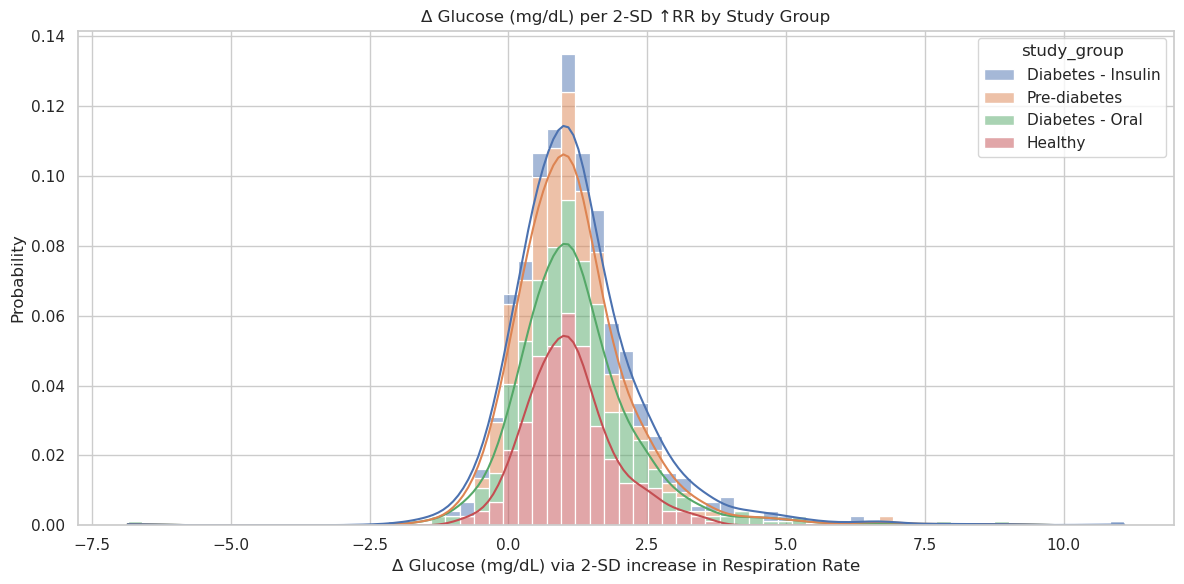

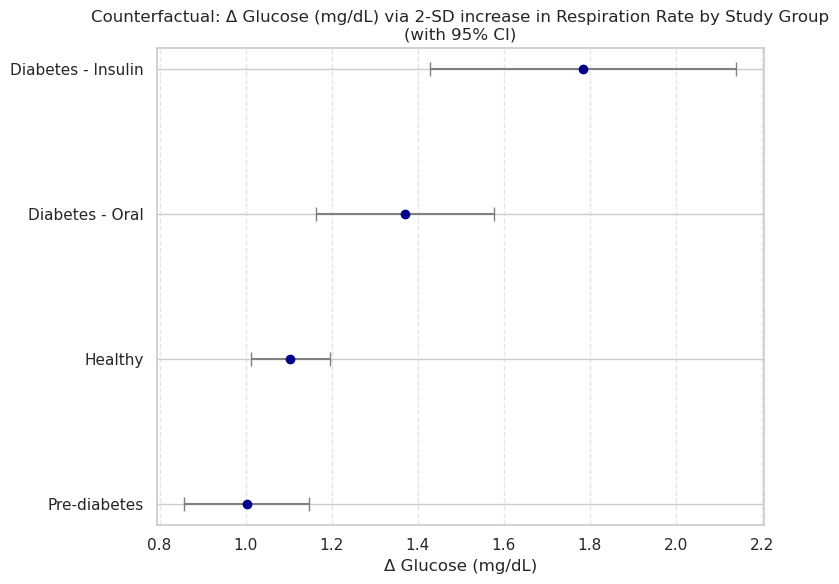

ANOVA p-value (across all study groups): 1.3582919e-06


In [25]:
# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import f_oneway


# Plot as distribution colored by study group - normalize the y axis
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_min_values,
    x='min_value',
    hue='study_group',
    multiple='stack',
    kde=True,
    stat='probability'  # This makes the y-axis a probability distribution
)
plt.title('Δ Glucose (mg/dL) per 2-SD ↑RR by Study Group')
plt.xlabel('Δ Glucose (mg/dL) via 2-SD increase in Respiration Rate')
plt.ylabel('Probability')
#plt.legend(title='Study Group')
plt.tight_layout()
plt.show()


# Plot average effect and CI (or standard error) for each study group using df_min_values
# Order the study groups by their average minimum value
# Have it renamed (Healthy, Pre-diabetes, Diabetes - Oral, Diabetes - Insulin)
df_min_values['study_group'] = df_min_values['study_group'].replace({
    'healthy': 'Healthy',
    'pre_diabetes_lifestyle_controlled': 'Pre-diabetes',
    'oral_medication_and_or_non_insulin_injectable_medication_controlled': 'Diabetes - Oral',
    'insulin_dependent': 'Diabetes - Insulin'
})

# Calculate mean and confidence intervals for each study group
import scipy.stats as stats

group_stats = df_min_values.groupby('study_group')['min_value'].agg(['mean', 'count', 'std'])
group_stats['sem'] = group_stats['std'] / group_stats['count']**0.5
group_stats['ci_lower'] = group_stats['mean'] - 1.96 * group_stats['sem']
group_stats['ci_upper'] = group_stats['mean'] + 1.96 * group_stats['sem']
group_stats = group_stats.sort_values('mean')

# One-way ANOVA to compare means across study groups

# Prepare the data for ANOVA
groups = [df_min_values[df_min_values['study_group'] == g]['min_value'].dropna() for g in group_stats.index]
anova_stat, anova_pval = f_oneway(*groups)

# Forest plot (same as before)
plt.figure(figsize=(8, 6))
y_pos = range(len(group_stats))
plt.errorbar(group_stats['mean'], y_pos, xerr=[group_stats['mean']-group_stats['ci_lower'], group_stats['ci_upper']-group_stats['mean']],
             fmt='o', color='darkblue', ecolor='gray', capsize=5)
plt.yticks(y_pos, group_stats.index)
plt.xlabel('Δ Glucose (mg/dL)')
plt.title('Counterfactual: Δ Glucose (mg/dL) via 2-SD increase in Respiration Rate by Study Group\n(with 95% CI)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("ANOVA p-value (across all study groups):", anova_pval)

In [14]:
import pandas as pd

# 1) Align the key column name and dtype
#measurement_wide = measurement_wide.rename(columns={'person_id': 'participant_id'})
measurement_wide['participant_id'] = measurement_wide['participant_id'].astype('category')

# 2) Bring the index of df_min_values out as a column named participant_id
df_min_values = df_min_values.rename_axis('participant_id').reset_index()
df_min_values['participant_id'] = df_min_values['participant_id'].astype(str)

# 3) Make sure measurement_wide participant_id is also string-categorical (safe for merge)
measurement_wide['participant_id'] = measurement_wide['participant_id'].astype(str).astype('category')

# Sanity check: no duplicates
assert not measurement_wide['participant_id'].duplicated().any(), \
       "measurement_wide has duplicate participant_id values"
assert not df_min_values['participant_id'].duplicated().any(), \
       "df_min_values has duplicate participant_id values"

# 5) Merge
merged = pd.merge(
    measurement_wide,
    df_min_values,
    on='participant_id',
    how='inner',            # or 'inner' if you only want overlapping ids
    validate='one_to_one'  # change/remove if not one-to-one
)

In [15]:
CF_clin = merged

/tmp/ipykernel_2405/2668104550.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CFvoi['min_value'] = pd.to_numeric(CFvoi['min_value'], errors='coerce')
/tmp/ipykernel_2405/2668104550.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CFvoi[VOI] = pd.to_numeric(CFvoi[VOI], errors='coerce')


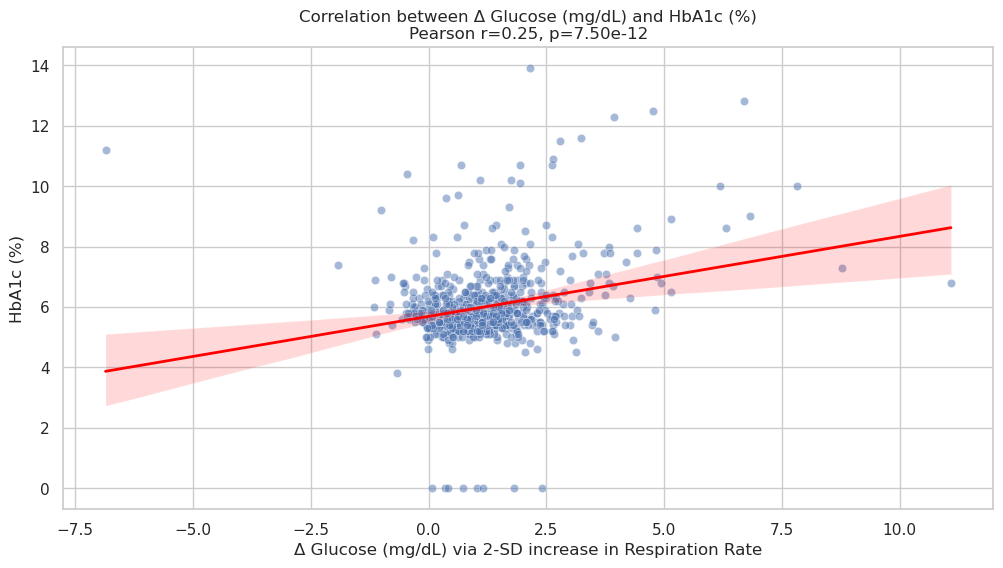

In [32]:
# Visualize regression and correlations and significance with min_value and HbA1c (%)
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 


#VOI = "HDL Cholesterol (mg/dL)"
#VOI = "Triglycerides (mg/dL)"
VOI = 'HbA1c (%)'
#VOI = 'pulse_vsorres, Heart Rate (bpm)'
#VOI = 'Glucose (mg/dL)'
#VOI = 'Total Cholesterol (mg/dL)'  # Example variable of interest

#Drop rows with NaN values in 'min_value' or VOI
CFvoi = CF_clin.dropna(subset=['min_value', VOI])

# Make sure both min_value and HbA1c (%) are numeric
CFvoi['min_value'] = pd.to_numeric(CFvoi['min_value'], errors='coerce')
CFvoi[VOI] = pd.to_numeric(CFvoi[VOI], errors='coerce')

# Set the style of seaborn
sns.set(style="whitegrid")
# Create a scatter plot with correlation and p-value significance:

plt.figure(figsize=(12, 6))
sns.scatterplot(x='min_value', y=VOI, data=CFvoi, alpha=0.5)
sns.regplot(x='min_value', y=VOI, data=CFvoi, scatter=False, color='red', line_kws={'lw':2})

# Calculate correlation and p-value
corr, pval = pearsonr(CFvoi['min_value'], CFvoi[VOI])
plt.title(f'Correlation between Δ Glucose (mg/dL) and {VOI}\nPearson r={corr:.2f}, p={pval:.2e}')
plt.xlabel('Δ Glucose (mg/dL) via 2-SD increase in Respiration Rate')
plt.ylabel(VOI)
plt.show()

       HOMAIR  min_value
0    0.726096  -0.843351
1    0.225889   1.016263
2    0.071688   1.560739
3    0.394585  -6.858631
4    0.085704   1.627976
..        ...        ...
736  0.235926   2.799107
737  0.604938   1.506696
738  0.192346   1.221859
739  0.323457   1.006962
740  0.083951  -1.113217

[718 rows x 2 columns]


/tmp/ipykernel_2405/678099044.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CFvoi['min_value'] = pd.to_numeric(CFvoi['min_value'], errors='coerce')
/tmp/ipykernel_2405/678099044.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CFvoi[VOI] = pd.to_numeric(CFvoi[VOI], errors='coerce')


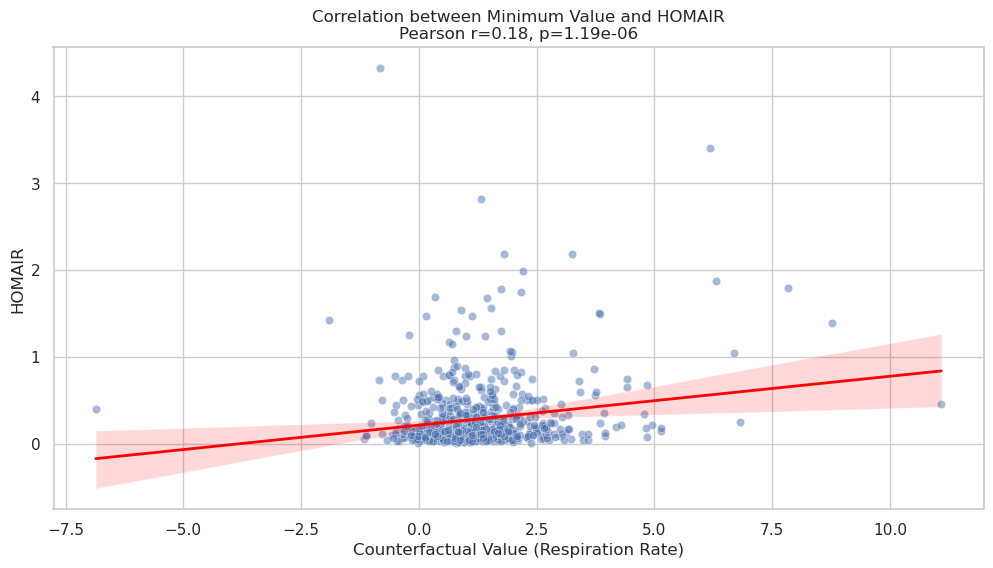

In [30]:
# Create a new column called IR_pred which is triglycerides over HDL
CF_clin['IR_pred'] = CF_clin['Triglycerides (mg/dL)'] / CF_clin['HDL Cholesterol (mg/dL)']
CF_clin['HOMAIR'] = (CF_clin['Glucose (mg/dL)'] * CF_clin['INSULIN (ng/mL)']) / 405
CF_clin['HOMABETA'] = 8640 * CF_clin['INSULIN (ng/mL)'] / (CF_clin['Glucose (mg/dL)'] - 63)


#VOI = "IR_pred"
VOI = "HOMAIR"
#VOI = "HOMABETA"

#Drop rows with NaN values in 'min_value' or VOI
CFvoi = CF_clin.dropna(subset=['min_value', VOI])
print(CFvoi[[VOI, 'min_value']])

# Make sure both min_value and HbA1c (%) are numeric
CFvoi['min_value'] = pd.to_numeric(CFvoi['min_value'], errors='coerce')
CFvoi[VOI] = pd.to_numeric(CFvoi[VOI], errors='coerce')

# Set the style of seaborn
sns.set(style="whitegrid")
# Create a scatter plot with correlation and p-value significance:

plt.figure(figsize=(12, 6))
sns.scatterplot(x='min_value', y=VOI, data=CFvoi, alpha=0.5)
sns.regplot(x='min_value', y=VOI, data=CFvoi, scatter=False, color='red', line_kws={'lw':2})

# Calculate correlation and p-value
corr, pval = pearsonr(CFvoi['min_value'], CFvoi[VOI])
plt.title(f'Correlation between Minimum Value and {VOI}\nPearson r={corr:.2f}, p={pval:.2e}')
plt.xlabel('Counterfactual Value (Respiration Rate)')
plt.ylabel(VOI)
plt.show()

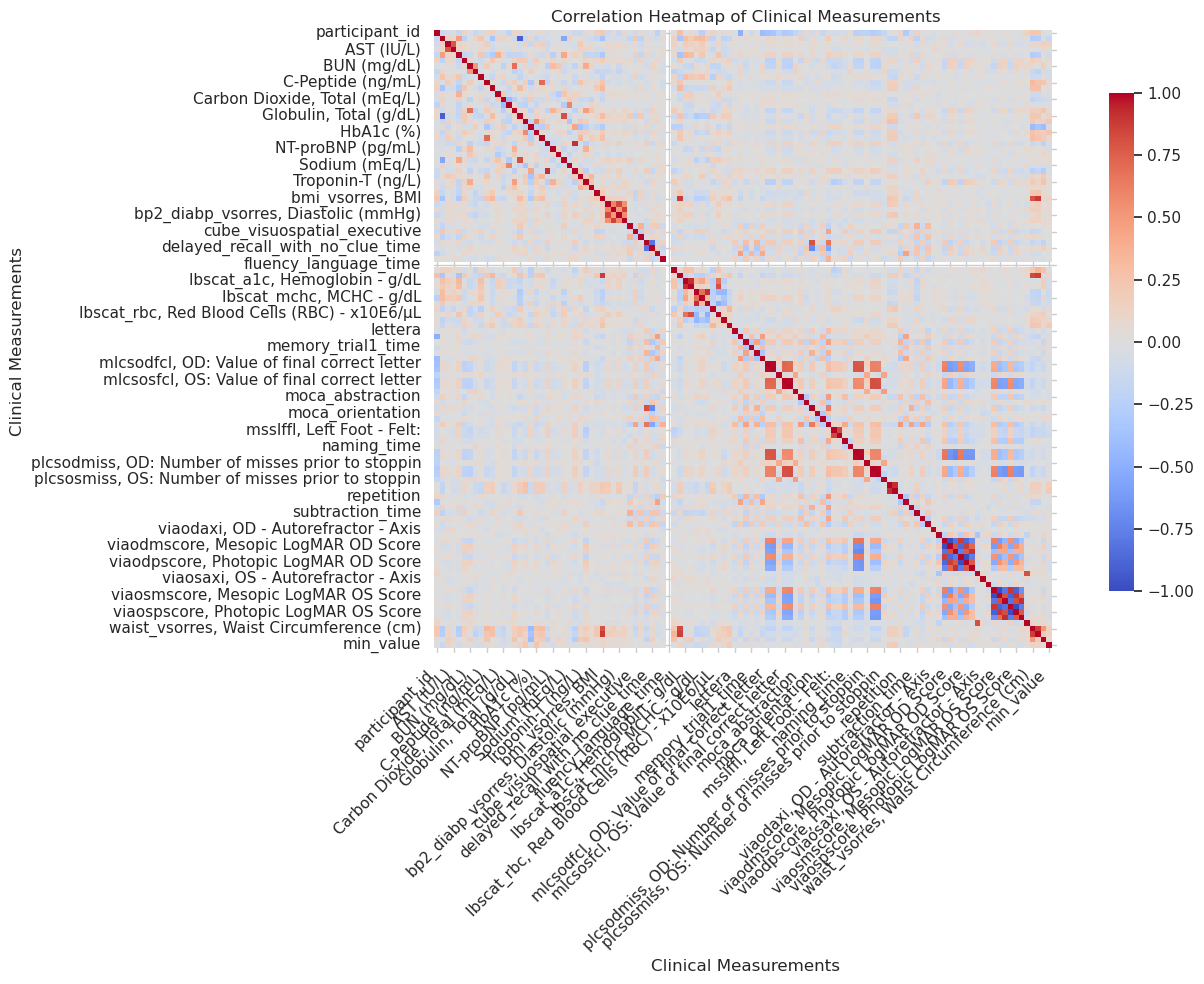

In [21]:
# Show heatmap of correlations between min_value and other clinical measurements
plt.figure(figsize=(14, 10))

# Convert columns to numeric for all columns in CF_clin
CF_clin_numeric = CF_clin.copy() #CF_clin.select_dtypes(include=['number']).copy()
CF_clin_numeric = CF_clin_numeric.apply(pd.to_numeric, errors='coerce')

correlation_matrix = CF_clin_numeric.corr()
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Clinical Measurements')
plt.xlabel('Clinical Measurements')
plt.ylabel('Clinical Measurements')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:
# Find highest correlations with min_value
min_value_corr = CF_clin_numeric.corr()['min_value'].sort_values(ascending=False)
print("Highest correlations with min_value:")
print(min_value_corr[min_value_corr.abs() > 0.5])  # Show only correlations above 0.5 or below -0.5
print("\nHighest correlations with min_value (absolute values):")       
print(min_value_corr.abs().sort_values(ascending=False).head(20))  # Show top 10 absolute correlations


Highest correlations with min_value:
min_value    1.0
Name: min_value, dtype: float64

Highest correlations with min_value (absolute values):
min_value                                         1.000000
HbA1c (%)                                         0.251694
Glucose (mg/dL)                                   0.219995
lbscat_wbc, White Blood Cells (WBC) - x10E3/µL    0.207575
pulse_vsorres_2, Heart Rate (bpm)                 0.199475
pulse_vsorres, Heart Rate (bpm)                   0.183934
A/G Ratio                                         0.153051
waist_vsorres, Waist Circumference (cm)           0.145847
Globulin, Total (g/dL)                            0.140188
hip_vsorres, Hip Circumference (cm)               0.129642
ALT (IU/L)                                        0.126574
weight_vsorres, Weight (kilograms)                0.125257
lbscat_mch, MCH - pg                              0.121418
bmi_vsorres, BMI                                  0.117236
mssrffl, Right Foot - Felt:     

In [23]:
# Of the correlations with min_value, are they significantly correlated?
import numpy as np
from scipy.stats import pearsonr    
# Iterate through each column in CF_clin_numeric to find significant correlations with min_value
significant_correlations = {}
for column in CF_clin_numeric.columns:
    #Drop NaN values for both min_value and the current column before pearsonr
    CF_clin_numeric_filtered = CF_clin_numeric[['min_value', column]].dropna()

    # Satisfy the condition that both columns have enough data points
    if len(CF_clin_numeric_filtered) < 2:
        continue

    if column != 'min_value':  # Skip the min_value column itself
        corr, pval = pearsonr(CF_clin_numeric_filtered['min_value'], CF_clin_numeric_filtered[column])
        if pval < 0.05:  # Check for significance at alpha=0.05
            significant_correlations[column] = (corr, pval)
# Print significant correlations
print("Significant correlations with min_value (p < 0.05):")
for col, (corr, pval) in significant_correlations.items():
    print(f"{col}: r={corr:.2f}, p={pval:.2e}")

Significant correlations with min_value (p < 0.05):
A/G Ratio: r=-0.15, p=3.72e-05
ALT (IU/L): r=0.13, p=6.64e-04
Albumin (g/dL): r=-0.10, p=8.55e-03
BUN/Creatinine ratio: r=-0.08, p=4.17e-02
Globulin, Total (g/dL): r=0.14, p=1.61e-04
Glucose (mg/dL): r=0.22, p=2.43e-09
HbA1c (%): r=0.25, p=7.50e-12
bmi_vsorres, BMI: r=0.12, p=1.41e-03
hip_vsorres, Hip Circumference (cm): r=0.13, p=4.18e-04
lbscat_a1c, Hemoglobin - g/dL: r=-0.09, p=1.33e-02
lbscat_mch, MCH - pg: r=-0.12, p=1.08e-03
lbscat_mchc, MCHC - g/dL: r=-0.11, p=4.32e-03
lbscat_mcv, MCV - fL: r=-0.10, p=8.92e-03
lbscat_plt, Platelets - x10E3/µL: r=0.08, p=2.28e-02
lbscat_rdw, RDW - %: r=0.09, p=1.62e-02
lbscat_wbc, White Blood Cells (WBC) - x10E3/µL: r=0.21, p=1.81e-08
msslffl, Left Foot - Felt:: r=-0.09, p=1.01e-02
mssrffl, Right Foot - Felt:: r=-0.12, p=1.73e-03
pulse_vsorres, Heart Rate (bpm): r=0.18, p=4.62e-07
pulse_vsorres_2, Heart Rate (bpm): r=0.20, p=4.54e-08
subtraction: r=-0.08, p=4.06e-02
waist_vsorres, Waist Circumfe

/tmp/ipykernel_2405/764023534.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(CF_clin_numeric_filtered['min_value'], CF_clin_numeric_filtered[column])
